<a href="https://colab.research.google.com/github/Pattaratron/BSC_DPDM23/blob/main/test%20midterm_bscdpdm23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

เตรียมข้อมูลอุตุนิยมวิทยา (https://drive.google.com/drive/folders/1k6tJcTTv2bKmFz6A5oOWi-sAeTVIQpG4?usp=sharing)

ให้เตรียมข้อมูลลักษณะอากาศของแต่ละวัน (แก้ missing, noise, ฯลฯ ) และสร้างตารางเพื่อทำการทำนาย ปริมาณน้ำฝนสำหรับจังหวัดขอนแก่นของวันถัดไป (ปริมาณน้ำฝนขอนแก่นของวันที่ D+1) จากข้อมูลลักษณะอากาศในจังหวัดต่างๆ (ขอนแก่น,หนองคาย,นครพนม,เลย,สกลนคร) ของวันปัจจุบัน (อุณหภูมิตุ้มแห้งขอนแก่นของวันที่ D,...,ความเร็วลมสกลนครของวันที่ D)


ตัวอย่างตารางที่ต้องการ (Xi มีทั้งหมด 5จังหวัด * 8ลักษณะอากาศ = 40 columns และ Y อีก 1 columns)

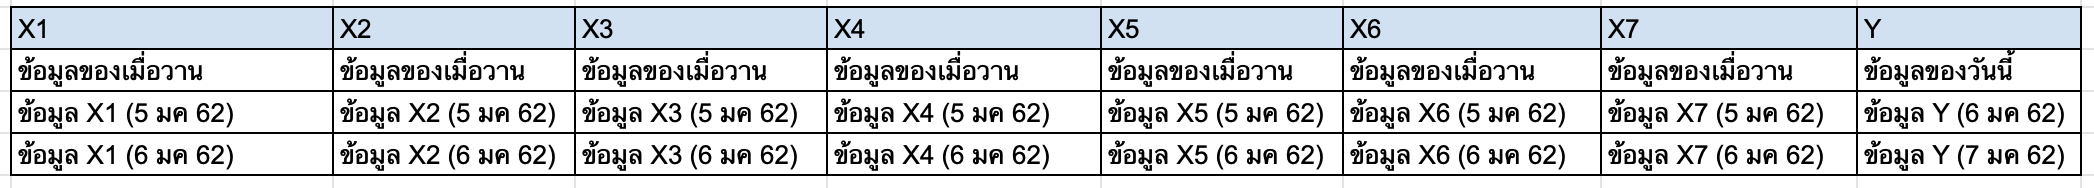

In [125]:
import numpy as np
import pandas as pd
import os

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#ขอนแก่น

##นําข้อมูลเข้าสู่dataขอนแก่น

In [127]:
khonkean_ap_p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความกด(เปอร์เซ็นต์)/จ.ขอนแก่น.xlsx', skiprows=4)
khonkean_rh_p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความชื้นสัมพัทธ์(เปอร์เซ็นต์)/จ.ขอนแก่น.xlsx', skiprows=4)
khonkean_ws_knot = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความเร็วลม(นอต)/จ.ขอนแก่น.xlsx', skiprows=4)
khonkean_ca_10p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/จำนวนเมฆ(10ส่วน)/จ.ขอนแก่น.xlsx', skiprows=4)
khonkean_rf_mm = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ปริมาณฝน(มิลลิเมตร)/จ.ขอนแก่น.xlsx', skiprows=4)
khonkean_dpm_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.ขอนแก่น.xlsx', skiprows=4)
khonkean_dm_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิตุ้มแห้ง(เซลเซียส)/จ.ขอนแก่น.xlsx', skiprows=4)
khonkean_lt_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิต่ำสุด(เซลเซียส)/จ.ขอนแก่น.xlsx', skiprows=4)

###ความกด(เปอร์เซ็นต์)ขอนแก่น

In [128]:
#เปลี่ยนชื่อหัวคอลลัมน์
khonkean_ap_p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
khonkean_ap_p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
khonkean_ap_p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
khonkean_ap_p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
khonkean_ap_p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
khonkean_ap_p['ปี'] = khonkean_ap_p['เดือนปี'].dt.year
khonkean_ap_p['เดือน'] = khonkean_ap_p['เดือนปี'].dt.month
khonkean_ap_p = khonkean_ap_p.drop(['เดือนปี','เฉลี่ย'], axis =1)
khonkean_ap_p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
khonkean_ap_p_data = khonkean_ap_p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
khonkean_ap_p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
khonkean_ap_p_data.rename(columns={0 : 'ความกด(เปอร์เซ็นต์)'},inplace=True)
khonkean_ap_p_data

#เพิ่มรหัสจังหวัด
khonkean_ap_p_data['จังหวัด'] = len(khonkean_ap_p_data)*['Khonkean']
khonkean_ap_p_data

#ทำ index เพื่อเตรียมทำ primary key
khonkean_ap_p_data1 = khonkean_ap_p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']].reset_index()
khonkean_ap_p_ndata = khonkean_ap_p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
khonkean_ap_p_ndata

#ใส่ key เพื่อเตรียม merge
khonkean_ap_p_ndata["รหัสจังหวัด"] = khonkean_ap_p_ndata["จังหวัด"].astype(str)  + khonkean_ap_p_ndata["index"].astype(str)
khonkean_ap_p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
khonkean_ap_p_pdata = khonkean_ap_p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
khonkean_ap_p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์)
0,Khonkean0,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.47
1,Khonkean1,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.65
2,Khonkean2,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.49
3,Khonkean3,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.28
4,Khonkean4,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.88
...,...,...,...,...,...,...,...
1700,Khonkean1700,Khonkean,352201-หนองคาย จ.หนองคาย,2022,2,27,1014.37
1701,Khonkean1701,Khonkean,352201-หนองคาย จ.หนองคาย,2022,2,28,1013.04
1702,Khonkean1702,Khonkean,352201-หนองคาย จ.หนองคาย,2022,2,29,1013.37
1703,Khonkean1703,Khonkean,352201-หนองคาย จ.หนองคาย,2022,2,30,1013.98


###ความชื่นสัมพันธ์(เปอร์เซ็นต์)ขอนแก่น

In [129]:
khonkean_rh_p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
khonkean_rh_p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
khonkean_rh_p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
khonkean_rh_p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
khonkean_rh_p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
khonkean_rh_p['ปี'] = khonkean_rh_p['เดือนปี'].dt.year
khonkean_rh_p['เดือน'] = khonkean_rh_p['เดือนปี'].dt.month
khonkean_rh_p = khonkean_rh_p.drop(['เดือนปี','เฉลี่ย'], axis =1)
khonkean_rh_p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
khonkean_rh_p_data = khonkean_rh_p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
khonkean_rh_p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
khonkean_rh_p_data.rename(columns={0 : 'ความชื้นสัมพัทธ์(เปอร์เซ็นต์)'},inplace=True)
khonkean_rh_p_data

#เพิ่มจังหวัด
khonkean_rh_p_data['จังหวัด'] = len(khonkean_rh_p_data)*['Khonkean']
khonkean_rh_p_data

#ทำ index เพื่อเตรียมทำ primary key
khonkean_rh_p_data1 = khonkean_rh_p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']].reset_index()
khonkean_rh_p_ndata = khonkean_rh_p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
khonkean_rh_p_ndata

#ใส่ key เพื่อเตรียม merge
khonkean_rh_p_ndata["รหัสจังหวัด"] = khonkean_rh_p_ndata["จังหวัด"].astype(str)  + khonkean_rh_p_ndata["index"].astype(str)
khonkean_rh_p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
khonkean_rh_p_pdata = khonkean_rh_p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
khonkean_rh_p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความชื้นสัมพัทธ์(เปอร์เซ็นต์)
0,Khonkean0,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,1,83
1,Khonkean1,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,2,92
2,Khonkean2,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,3,86
3,Khonkean3,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,4,80
4,Khonkean4,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,5,86
...,...,...,...,...,...,...,...
1700,Khonkean1700,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,27,58
1701,Khonkean1701,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,28,62
1702,Khonkean1702,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,29,-
1703,Khonkean1703,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,30,-


###ความเร็วลม(นอต)ขอนแก่น

In [130]:
khonkean_ws_knot.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
khonkean_ws_knot.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
khonkean_ws_knot.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
khonkean_ws_knot.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
khonkean_ws_knot
# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
khonkean_ws_knot['ปี'] = khonkean_ws_knot['เดือนปี'].dt.year
khonkean_ws_knot['เดือน'] = khonkean_ws_knot['เดือนปี'].dt.month
khonkean_ws_knot= khonkean_ws_knot.drop(['เดือนปี','เฉลี่ย'], axis =1)
khonkean_ws_knot

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
khonkean_ws_knot_data = khonkean_ws_knot.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
khonkean_ws_knot_data.rename(columns={'level_4' : 'วัน'},inplace=True)
khonkean_ws_knot_data.rename(columns={0 : 'ความเร็วลม(นอต)'},inplace=True)
khonkean_ws_knot_data

#เพิ่มจังหวัด
khonkean_ws_knot_data['จังหวัด'] = len(khonkean_ws_knot_data)*['Khonkean']
khonkean_ws_knot_data

#ทำ index เพื่อเตรียมทำ primary key
khonkean_ws_knot_data1 = khonkean_ws_knot_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']].reset_index()
khonkean_ws_knot_ndata = khonkean_ws_knot_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']]
khonkean_ws_knot_ndata

#ใส่ key เพื่อเตรียม merge
khonkean_ws_knot_ndata["รหัสจังหวัด"] = khonkean_ws_knot_ndata["จังหวัด"].astype(str)  + khonkean_ws_knot_ndata["index"].astype(str)
khonkean_ws_knot_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
khonkean_ws_knot_pdata = khonkean_ws_knot_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']]
khonkean_ws_knot_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความเร็วลม(นอต)
0,Khonkean0,Khonkean,353301-เลย สกษ. จ.เลย,2011,10,1,3
1,Khonkean1,Khonkean,353301-เลย สกษ. จ.เลย,2011,10,2,2
2,Khonkean2,Khonkean,353301-เลย สกษ. จ.เลย,2011,10,3,3
3,Khonkean3,Khonkean,353301-เลย สกษ. จ.เลย,2011,10,4,2
4,Khonkean4,Khonkean,353301-เลย สกษ. จ.เลย,2011,10,5,2
...,...,...,...,...,...,...,...
1700,Khonkean1700,Khonkean,353301-เลย สกษ. จ.เลย,2022,2,27,2
1701,Khonkean1701,Khonkean,353301-เลย สกษ. จ.เลย,2022,2,28,2
1702,Khonkean1702,Khonkean,353301-เลย สกษ. จ.เลย,2022,2,29,-
1703,Khonkean1703,Khonkean,353301-เลย สกษ. จ.เลย,2022,2,30,-


###จํานวนเมฆ(10ส่วน)ขอนแก่น

In [131]:
khonkean_ca_10p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
khonkean_ca_10p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
khonkean_ca_10p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
khonkean_ca_10p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
khonkean_ca_10p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
khonkean_ca_10p['ปี'] = khonkean_ca_10p['เดือนปี'].dt.year
khonkean_ca_10p['เดือน'] = khonkean_ca_10p['เดือนปี'].dt.month
khonkean_ca_10p = khonkean_ca_10p.drop(['เดือนปี','เฉลี่ย'], axis =1)
khonkean_ca_10p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
khonkean_ca_10p_data = khonkean_ca_10p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
khonkean_ca_10p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
khonkean_ca_10p_data.rename(columns={0 : 'จํานวนเมฆ(10ส่วน)'},inplace=True)
khonkean_ca_10p_data

#เพิ่มจังหวัด
khonkean_ca_10p_data['จังหวัด'] = len(khonkean_ca_10p_data)*['Khonkean']
khonkean_ca_10p_data

#ทำ index เพื่อเตรียมทำ primary key
khonkean_ca_10p_data1 = khonkean_ca_10p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']].reset_index()
khonkean_ca_10p_ndata = khonkean_ca_10p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']]
khonkean_ca_10p_ndata

#ใส่ key เพื่อเตรียม merge
khonkean_ca_10p_ndata["รหัสจังหวัด"] = khonkean_ca_10p_ndata["จังหวัด"].astype(str)  + khonkean_ca_10p_ndata["index"].astype(str)
khonkean_ca_10p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
khonkean_ca_10p_pdata = khonkean_ca_10p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']]
khonkean_ca_10p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,จํานวนเมฆ(10ส่วน)
0,Khonkean0,Khonkean,353301-เลย สกษ. จ.เลย,2011,10,1,9
1,Khonkean1,Khonkean,353301-เลย สกษ. จ.เลย,2011,10,2,10
2,Khonkean2,Khonkean,353301-เลย สกษ. จ.เลย,2011,10,3,10
3,Khonkean3,Khonkean,353301-เลย สกษ. จ.เลย,2011,10,4,8
4,Khonkean4,Khonkean,353301-เลย สกษ. จ.เลย,2011,10,5,10
...,...,...,...,...,...,...,...
1700,Khonkean1700,Khonkean,353301-เลย สกษ. จ.เลย,2022,2,27,2
1701,Khonkean1701,Khonkean,353301-เลย สกษ. จ.เลย,2022,2,28,2
1702,Khonkean1702,Khonkean,353301-เลย สกษ. จ.เลย,2022,2,29,-
1703,Khonkean1703,Khonkean,353301-เลย สกษ. จ.เลย,2022,2,30,-


###ปริมาณฝน(มิลลิเมตร)ขอนแก่น

In [132]:
khonkean_rf_mm.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
khonkean_rf_mm.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
khonkean_rf_mm.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
khonkean_rf_mm.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
khonkean_rf_mm

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
khonkean_rf_mm['ปี'] = khonkean_rf_mm['เดือนปี'].dt.year
khonkean_rf_mm['เดือน'] =khonkean_rf_mm['เดือนปี'].dt.month
khonkean_rf_mm = khonkean_rf_mm.drop(['เดือนปี','เฉลี่ย'], axis =1)
khonkean_rf_mm

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
khonkean_rf_mm_data = khonkean_rf_mm.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
khonkean_rf_mm_data.rename(columns={'level_4' : 'วัน'},inplace=True)
khonkean_rf_mm_data.rename(columns={0 : 'ปริมาณฝน(มิลลิเมตร)'},inplace=True)
khonkean_rf_mm_data

#เพิ่มจังหวัด
khonkean_rf_mm_data['จังหวัด'] = len(khonkean_rf_mm_data)*['Khonkean']
khonkean_rf_mm_data

#ทำ index เพื่อเตรียมทำ primary key
khonkean_rf_mm_data1 = khonkean_rf_mm_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']].reset_index()
khonkean_rf_mm_ndata = khonkean_rf_mm_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']]
khonkean_rf_mm_ndata

#ใส่ key เพื่อเตรียม merge
khonkean_rf_mm_ndata["รหัสจังหวัด"] = khonkean_rf_mm_ndata["จังหวัด"].astype(str)  + khonkean_rf_mm_ndata["index"].astype(str)
khonkean_rf_mm_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
khonkean_rf_mm_pdata = khonkean_rf_mm_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']]
khonkean_rf_mm_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ปริมาณฝน(มิลลิเมตร)
0,Khonkean0,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,1,1.4
1,Khonkean1,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,2,17.7
2,Khonkean2,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,3,3
3,Khonkean3,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,4,0
4,Khonkean4,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,5,2.2
...,...,...,...,...,...,...,...
1700,Khonkean1700,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,27,0
1701,Khonkean1701,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,28,-
1702,Khonkean1702,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,29,-
1703,Khonkean1703,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,30,-


###อุณหภูมิจุดนํ้าค้าง(เซลเซียส)ขอนแก่น

In [133]:
khonkean_dpm_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
khonkean_dpm_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
khonkean_dpm_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
khonkean_dpm_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
khonkean_dpm_c

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
khonkean_dpm_c['ปี'] = khonkean_dpm_c['เดือนปี'].dt.year
khonkean_dpm_c['เดือน'] = khonkean_dpm_c['เดือนปี'].dt.month
khonkean_dpm_c = khonkean_dpm_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
khonkean_dpm_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
khonkean_dpm_c_data = khonkean_dpm_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
khonkean_dpm_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
khonkean_dpm_c_data.rename(columns={0 : 'อุณหภูมิจุดนํ้าค้าง(เซลเซียส)'},inplace=True)
khonkean_dpm_c_data

#เพิ่มจังหวัด
khonkean_dpm_c_data['จังหวัด'] = len(khonkean_dpm_c_data)*['Khonkean']
khonkean_dpm_c_data

#ทำ index เพื่อเตรียมทำ primary key
khonkean_dpm_c_data1 = khonkean_dpm_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']].reset_index()
khonkean_dpm_c_ndata = khonkean_dpm_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
khonkean_dpm_c_ndata

#ใส่ key เพื่อเตรียม merge
khonkean_dpm_c_ndata["รหัสจังหวัด"] = khonkean_dpm_c_ndata["จังหวัด"].astype(str)  + khonkean_dpm_c_ndata["index"].astype(str)
khonkean_dpm_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
khonkean_dpm_c_pdata = khonkean_dpm_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
khonkean_dpm_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิจุดนํ้าค้าง(เซลเซียส)
0,Khonkean0,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,1,24.2
1,Khonkean1,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,2,24.0
2,Khonkean2,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,3,22.9
3,Khonkean3,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,4,21.9
4,Khonkean4,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,5,21.7
...,...,...,...,...,...,...,...
1700,Khonkean1700,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,27,15.7
1701,Khonkean1701,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,28,17.5
1702,Khonkean1702,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,29,-
1703,Khonkean1703,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,30,-


###อุณหภูมิตุ้มแห้ง(เซลเซียส)ขอนแก่น

In [134]:
khonkean_dm_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
khonkean_dm_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
khonkean_dm_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
khonkean_dm_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
khonkean_dm_c
# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
khonkean_dm_c['ปี'] = khonkean_dm_c['เดือนปี'].dt.year
khonkean_dm_c['เดือน'] = khonkean_dm_c['เดือนปี'].dt.month
khonkean_dm_c = khonkean_dm_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
khonkean_dm_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
khonkean_dm_c_data = khonkean_dm_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
khonkean_dm_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
khonkean_dm_c_data.rename(columns={0 : 'อุณหภูมิตุ้มแห้ง(เซลเซียส)'},inplace=True)
khonkean_dm_c_data

#เพิ่มจังหวัด
khonkean_dm_c_data['จังหวัด'] = len(khonkean_dm_c_data)*['Khonkean']
khonkean_dm_c_data

#ทำ index เพื่อเตรียมทำ primary key
khonkean_dm_c_data1 = khonkean_dm_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']].reset_index()
khonkean_dm_c_ndata = khonkean_dm_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
khonkean_dm_c_ndata

#ใส่ key เพื่อเตรียม merge
khonkean_dm_c_ndata["รหัสจังหวัด"] = khonkean_dm_c_ndata["จังหวัด"].astype(str)  + khonkean_dm_c_ndata["index"].astype(str)
khonkean_dm_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
khonkean_dm_c_pdata = khonkean_dm_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
khonkean_dm_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิตุ้มแห้ง(เซลเซียส)
0,Khonkean0,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,1,27.6
1,Khonkean1,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,2,25.6
2,Khonkean2,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,3,25.6
3,Khonkean3,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,4,25.8
4,Khonkean4,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,5,24.3
...,...,...,...,...,...,...,...
1700,Khonkean1700,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,27,25.1
1701,Khonkean1701,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,28,25.9
1702,Khonkean1702,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,29,-
1703,Khonkean1703,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,30,-


###อุณหภูมิตํ่าสุด(เซลเซียส)ขอนแก่น

In [135]:
khonkean_lt_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
khonkean_lt_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
khonkean_lt_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
khonkean_lt_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
khonkean_lt_c

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
khonkean_lt_c['ปี'] = khonkean_lt_c['เดือนปี'].dt.year
khonkean_lt_c['เดือน'] = khonkean_lt_c['เดือนปี'].dt.month
khonkean_lt_c = khonkean_lt_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
khonkean_lt_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
khonkean_lt_c_data = khonkean_lt_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
khonkean_lt_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
khonkean_lt_c_data.rename(columns={0 : 'อุณหภูมิตํ่าสุด(เซลเซียส)'},inplace=True)
khonkean_lt_c_data

#เพิ่มจังหวัด
khonkean_lt_c_data['จังหวัด'] = len(khonkean_lt_c_data)*['Khonkean']
khonkean_lt_c_data

#ทำ index เพื่อเตรียมทำ primary key
khonkean_lt_c_data1 = khonkean_lt_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']].reset_index()
khonkean_lt_c_ndata = khonkean_lt_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']]
khonkean_lt_c_ndata

#ใส่ key เพื่อเตรียม merge
khonkean_lt_c_ndata["รหัสจังหวัด"] = khonkean_lt_c_ndata["จังหวัด"].astype(str)  + khonkean_lt_c_ndata["index"].astype(str)
khonkean_lt_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
khonkean_lt_c_pdata = khonkean_lt_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']]
khonkean_lt_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิตํ่าสุด(เซลเซียส)
0,Khonkean0,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,1,24.8
1,Khonkean1,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,2,23.0
2,Khonkean2,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,3,22.1
3,Khonkean3,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,4,22.8
4,Khonkean4,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2011,10,5,23.1
...,...,...,...,...,...,...,...
1700,Khonkean1700,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,27,18.2
1701,Khonkean1701,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,28,-
1702,Khonkean1702,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,29,-
1703,Khonkean1703,Khonkean,381201-ขอนแก่น จ.ขอนแก่น,2022,2,30,-


###รวมตารางขอนแก่น

In [179]:
kk1 = khonkean_ap_p_pdata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
kk2 =  khonkean_rh_p_pdata[['รหัสจังหวัด','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
kk3 =   khonkean_ws_knot_pdata[['รหัสจังหวัด','ความเร็วลม(นอต)']]
kk4 =  khonkean_ca_10p_pdata[['รหัสจังหวัด','จํานวนเมฆ(10ส่วน)']]
kk5 =   khonkean_rf_mm_pdata[['รหัสจังหวัด','ปริมาณฝน(มิลลิเมตร)']]
kk6 =   khonkean_dpm_c_pdata[['รหัสจังหวัด','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
kk7 = khonkean_dm_c_pdata[['รหัสจังหวัด','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
kk8 = khonkean_lt_c_pdata[['รหัสจังหวัด','อุณหภูมิตํ่าสุด(เซลเซียส)']]

In [180]:
merged_kk = pd.merge(kk1, kk2, how='inner')
merged_kk = pd.merge(merged_kk, kk3, how='inner')
merged_kk = pd.merge(merged_kk, kk4, how='inner')
merged_kk = pd.merge(merged_kk, kk5, how='inner')
merged_kk = pd.merge(merged_kk, kk6, how='inner')
merged_kk = pd.merge(merged_kk, kk7, how='inner')
merged_kk = pd.merge(merged_kk, kk8, how='inner')
merged_kk

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส)
0,Khonkean0,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.47,83,3,9,1.4,24.2,27.6,24.8
1,Khonkean1,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.65,92,2,10,17.7,24.0,25.6,23.0
2,Khonkean2,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.49,86,3,10,3,22.9,25.6,22.1
3,Khonkean3,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.28,80,2,8,0,21.9,25.8,22.8
4,Khonkean4,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.88,86,2,10,2.2,21.7,24.3,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,Khonkean1700,Khonkean,352201-หนองคาย จ.หนองคาย,2022,2,27,1014.37,58,2,2,0,15.7,25.1,18.2
1701,Khonkean1701,Khonkean,352201-หนองคาย จ.หนองคาย,2022,2,28,1013.04,62,2,2,-,17.5,25.9,-
1702,Khonkean1702,Khonkean,352201-หนองคาย จ.หนองคาย,2022,2,29,1013.37,-,-,-,-,-,-,-
1703,Khonkean1703,Khonkean,352201-หนองคาย จ.หนองคาย,2022,2,30,1013.98,-,-,-,-,-,-,-


#หนองคาย

##นําข้อมูลเข้าสู่dataหนองคาย

In [136]:
nongkhai_ap_p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความกด(เปอร์เซ็นต์)/จ.หนองคาย.xlsx', skiprows=4)
nongkhai_rh_p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความชื้นสัมพัทธ์(เปอร์เซ็นต์)/จ.หนองคาย.xlsx', skiprows=4)
nongkhai_ws_knot = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความเร็วลม(นอต)/จ.หนองคาย.xlsx', skiprows=4)
nongkhai_ca_10p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/จำนวนเมฆ(10ส่วน)/จ.หนองคาย.xlsx', skiprows=4)
nongkhai_rf_mm = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ปริมาณฝน(มิลลิเมตร)/จ.หนองคาย.xlsx', skiprows=4)
nongkhai_dpm_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.หนองคาย.xlsx', skiprows=4)
nongkhai_dm_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิตุ้มแห้ง(เซลเซียส)/จ.หนองคาย.xlsx', skiprows=4)
nongkhai_lt_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิต่ำสุด(เซลเซียส)/จ.หนองคาย.xlsx', skiprows=4)

###ความกด(เปอร์เซ็นต์)หนองคาย

In [137]:
nongkhai_ap_p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nongkhai_ap_p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nongkhai_ap_p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nongkhai_ap_p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nongkhai_ap_p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nongkhai_ap_p['ปี'] = nongkhai_ap_p['เดือนปี'].dt.year
nongkhai_ap_p['เดือน'] = nongkhai_ap_p['เดือนปี'].dt.month
nongkhai_ap_p = nongkhai_ap_p.drop(['เดือนปี','เฉลี่ย'], axis =1)
nongkhai_ap_p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nongkhai_ap_p_data = nongkhai_ap_p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nongkhai_ap_p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nongkhai_ap_p_data.rename(columns={0 : 'ความกด(เปอร์เซ็นต์)'},inplace=True)
nongkhai_ap_p_data

#เพิ่มจังหวัด
nongkhai_ap_p_data['จังหวัด'] = len(nongkhai_ap_p_data)*['Nongkhai']
nongkhai_ap_p_data

#ทำ index เพื่อเตรียมทำ primary key
nongkhai_ap_p_data1 = nongkhai_ap_p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']].reset_index()
nongkhai_ap_p_ndata = nongkhai_ap_p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
nongkhai_ap_p_ndata

#ใส่ key เพื่อเตรียม merge
nongkhai_ap_p_ndata["รหัสจังหวัด"] = nongkhai_ap_p_ndata["จังหวัด"].astype(str)  + nongkhai_ap_p_ndata["index"].astype(str)
nongkhai_ap_p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nongkhai_ap_p_pdata = nongkhai_ap_p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
nongkhai_ap_p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์)
0,Nongkhai0,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.34
1,Nongkhai1,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.67
2,Nongkhai2,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.39
3,Nongkhai3,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.11
4,Nongkhai4,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.69
...,...,...,...,...,...,...,...
1700,Nongkhai1700,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,27,1015.31
1701,Nongkhai1701,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,28,1013.06
1702,Nongkhai1702,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,29,-
1703,Nongkhai1703,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,30,-


###ความชื่นสัมพันธ์(เปอร์เซ็นต์)หนองคาย

In [138]:
nongkhai_rh_p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nongkhai_rh_p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nongkhai_rh_p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nongkhai_rh_p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nongkhai_rh_p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nongkhai_rh_p['ปี'] = nongkhai_rh_p['เดือนปี'].dt.year
nongkhai_rh_p['เดือน'] = nongkhai_rh_p['เดือนปี'].dt.month
nongkhai_rh_p = nongkhai_rh_p.drop(['เดือนปี','เฉลี่ย'], axis =1)
nongkhai_rh_p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nongkhai_rh_p_data = nongkhai_rh_p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nongkhai_rh_p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nongkhai_rh_p_data.rename(columns={0 : 'ความชื้นสัมพัทธ์(เปอร์เซ็นต์)'},inplace=True)
nongkhai_rh_p_data

#เพิ่มจังหวัด
nongkhai_rh_p_data['จังหวัด'] = len(nongkhai_rh_p_data)*['Nongkhai']
nongkhai_rh_p_data

#ทำ index เพื่อเตรียมทำ primary key
nongkhai_rh_p_data1 = nongkhai_rh_p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']].reset_index()
nongkhai_rh_p_ndata = nongkhai_rh_p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
nongkhai_rh_p_ndata

#ใส่ key เพื่อเตรียม merge
nongkhai_rh_p_ndata["รหัสจังหวัด"] = nongkhai_rh_p_ndata["จังหวัด"].astype(str)  + nongkhai_rh_p_ndata["index"].astype(str)
nongkhai_rh_p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nongkhai_rh_p_pdata = nongkhai_rh_p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
nongkhai_rh_p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความชื้นสัมพัทธ์(เปอร์เซ็นต์)
0,Nongkhai0,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,1,89
1,Nongkhai1,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,2,91
2,Nongkhai2,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,3,78
3,Nongkhai3,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,4,75
4,Nongkhai4,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,5,90
...,...,...,...,...,...,...,...
1700,Nongkhai1700,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,27,62
1701,Nongkhai1701,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,28,65
1702,Nongkhai1702,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,29,-
1703,Nongkhai1703,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,30,-


###ความเร็วลม(นอต)หนองคาย

In [139]:
nongkhai_ws_knot.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nongkhai_ws_knot.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nongkhai_ws_knot.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nongkhai_ws_knot.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nongkhai_ws_knot
# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nongkhai_ws_knot['ปี'] = nongkhai_ws_knot['เดือนปี'].dt.year
nongkhai_ws_knot['เดือน'] = nongkhai_ws_knot['เดือนปี'].dt.month
nongkhai_ws_knot= nongkhai_ws_knot.drop(['เดือนปี','เฉลี่ย'], axis =1)
nongkhai_ws_knot

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nongkhai_ws_knot_data = nongkhai_ws_knot.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nongkhai_ws_knot_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nongkhai_ws_knot_data.rename(columns={0 : 'ความเร็วลม(นอต)'},inplace=True)
nongkhai_ws_knot_data

#เพิ่มจังหวัด
nongkhai_ws_knot_data['จังหวัด'] = len(nongkhai_ws_knot_data)*['Nongkhai']
nongkhai_ws_knot_data

#ทำ index เพื่อเตรียมทำ primary key
nongkhai_ws_knot_data1 = nongkhai_ws_knot_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']].reset_index()
nongkhai_ws_knot_ndata = nongkhai_ws_knot_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']]
nongkhai_ws_knot_ndata

#ใส่ key เพื่อเตรียม merge
nongkhai_ws_knot_ndata["รหัสจังหวัด"] = nongkhai_ws_knot_ndata["จังหวัด"].astype(str)  + nongkhai_ws_knot_ndata["index"].astype(str)
nongkhai_ws_knot_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nongkhai_ws_knot_pdata = nongkhai_ws_knot_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']]
nongkhai_ws_knot_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความเร็วลม(นอต)
0,Nongkhai0,Nongkhai,353301-เลย สกษ. จ.เลย,2011,10,1,1
1,Nongkhai1,Nongkhai,353301-เลย สกษ. จ.เลย,2011,10,2,4
2,Nongkhai2,Nongkhai,353301-เลย สกษ. จ.เลย,2011,10,3,4
3,Nongkhai3,Nongkhai,353301-เลย สกษ. จ.เลย,2011,10,4,2
4,Nongkhai4,Nongkhai,353301-เลย สกษ. จ.เลย,2011,10,5,1
...,...,...,...,...,...,...,...
1700,Nongkhai1700,Nongkhai,353301-เลย สกษ. จ.เลย,2022,2,27,2
1701,Nongkhai1701,Nongkhai,353301-เลย สกษ. จ.เลย,2022,2,28,2
1702,Nongkhai1702,Nongkhai,353301-เลย สกษ. จ.เลย,2022,2,29,-
1703,Nongkhai1703,Nongkhai,353301-เลย สกษ. จ.เลย,2022,2,30,-


###จํานวนเมฆ(10ส่วน)หนองคาย

In [140]:
nongkhai_ca_10p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nongkhai_ca_10p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nongkhai_ca_10p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nongkhai_ca_10p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nongkhai_ca_10p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nongkhai_ca_10p['ปี'] = nongkhai_ca_10p['เดือนปี'].dt.year
nongkhai_ca_10p['เดือน'] = nongkhai_ca_10p['เดือนปี'].dt.month
nongkhai_ca_10p = nongkhai_ca_10p.drop(['เดือนปี','เฉลี่ย'], axis =1)
nongkhai_ca_10p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nongkhai_ca_10p_data = nongkhai_ca_10p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nongkhai_ca_10p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nongkhai_ca_10p_data.rename(columns={0 : 'จํานวนเมฆ(10ส่วน)'},inplace=True)
nongkhai_ca_10p_data

#เพิ่มจังหวัด
nongkhai_ca_10p_data['จังหวัด'] = len(nongkhai_ca_10p_data)*['Nongkhai']
nongkhai_ca_10p_data

#ทำ index เพื่อเตรียมทำ primary key
nongkhai_ca_10p_data1 = nongkhai_ca_10p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']].reset_index()
nongkhai_ca_10p_ndata = nongkhai_ca_10p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']]
nongkhai_ca_10p_ndata

#ใส่ key เพื่อเตรียม merge
nongkhai_ca_10p_ndata["รหัสจังหวัด"] = nongkhai_ca_10p_ndata["จังหวัด"].astype(str)  + nongkhai_ca_10p_ndata["index"].astype(str)
nongkhai_ca_10p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nongkhai_ca_10p_pdata = nongkhai_ca_10p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']]
nongkhai_ca_10p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,จํานวนเมฆ(10ส่วน)
0,Nongkhai0,Nongkhai,353301-เลย สกษ. จ.เลย,2011,10,1,10
1,Nongkhai1,Nongkhai,353301-เลย สกษ. จ.เลย,2011,10,2,10
2,Nongkhai2,Nongkhai,353301-เลย สกษ. จ.เลย,2011,10,3,8
3,Nongkhai3,Nongkhai,353301-เลย สกษ. จ.เลย,2011,10,4,9
4,Nongkhai4,Nongkhai,353301-เลย สกษ. จ.เลย,2011,10,5,9
...,...,...,...,...,...,...,...
1697,Nongkhai1697,Nongkhai,353301-เลย สกษ. จ.เลย,2022,2,27,3
1698,Nongkhai1698,Nongkhai,353301-เลย สกษ. จ.เลย,2022,2,28,2
1699,Nongkhai1699,Nongkhai,353301-เลย สกษ. จ.เลย,2022,2,29,1
1700,Nongkhai1700,Nongkhai,353301-เลย สกษ. จ.เลย,2022,2,30,1


###ปริมาณฝน(มิลลิเมตร)หนองคาย

In [141]:
nongkhai_rf_mm.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nongkhai_rf_mm.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nongkhai_rf_mm.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nongkhai_rf_mm.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nongkhai_rf_mm

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nongkhai_rf_mm['ปี'] = nongkhai_rf_mm['เดือนปี'].dt.year
nongkhai_rf_mm['เดือน'] =nongkhai_rf_mm['เดือนปี'].dt.month
nongkhai_rf_mm = nongkhai_rf_mm.drop(['เดือนปี','เฉลี่ย'], axis =1)
nongkhai_rf_mm

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nongkhai_rf_mm_data = nongkhai_rf_mm.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nongkhai_rf_mm_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nongkhai_rf_mm_data.rename(columns={0 : 'ปริมาณฝน(มิลลิเมตร)'},inplace=True)
nongkhai_rf_mm_data

#เพิ่มจังหวัด
nongkhai_rf_mm_data['จังหวัด'] = len(nongkhai_rf_mm_data)*['Nongkhai']
nongkhai_rf_mm_data

#ทำ index เพื่อเตรียมทำ primary key
nongkhai_rf_mm_data1 = nongkhai_rf_mm_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']].reset_index()
nongkhai_rf_mm_ndata = nongkhai_rf_mm_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']]
nongkhai_rf_mm_ndata

#ใส่ key เพื่อเตรียม merge
nongkhai_rf_mm_ndata["รหัสจังหวัด"] = nongkhai_rf_mm_ndata["จังหวัด"].astype(str)  + nongkhai_rf_mm_ndata["index"].astype(str)
nongkhai_rf_mm_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nongkhai_rf_mm_pdata = nongkhai_rf_mm_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']]
nongkhai_rf_mm_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ปริมาณฝน(มิลลิเมตร)
0,Nongkhai0,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,1,48.6
1,Nongkhai1,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,2,59
2,Nongkhai2,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,3,0
3,Nongkhai3,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,4,1
4,Nongkhai4,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,5,19.1
...,...,...,...,...,...,...,...
1700,Nongkhai1700,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,27,0
1701,Nongkhai1701,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,28,0
1702,Nongkhai1702,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,29,-
1703,Nongkhai1703,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,30,-


###อุณหภูมิจุดนํ้าค้าง(เซลเซียส)หนองคาย

In [142]:
nongkhai_dpm_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nongkhai_dpm_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nongkhai_dpm_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nongkhai_dpm_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nongkhai_dpm_c

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nongkhai_dpm_c['ปี'] = nongkhai_dpm_c['เดือนปี'].dt.year
nongkhai_dpm_c['เดือน'] = nongkhai_dpm_c['เดือนปี'].dt.month
nongkhai_dpm_c = nongkhai_dpm_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
nongkhai_dpm_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nongkhai_dpm_c_data = nongkhai_dpm_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nongkhai_dpm_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nongkhai_dpm_c_data.rename(columns={0 : 'อุณหภูมิจุดนํ้าค้าง(เซลเซียส)'},inplace=True)
nongkhai_dpm_c_data

#เพิ่มจังหวัด
nongkhai_dpm_c_data['จังหวัด'] = len(nongkhai_dpm_c_data)*['Nongkhai']
nongkhai_dpm_c_data

#ทำ index เพื่อเตรียมทำ primary key
nongkhai_dpm_c_data1 = nongkhai_dpm_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']].reset_index()
nongkhai_dpm_c_ndata = nongkhai_dpm_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
nongkhai_dpm_c_ndata

#ใส่ key เพื่อเตรียม merge
nongkhai_dpm_c_ndata["รหัสจังหวัด"] = nongkhai_dpm_c_ndata["จังหวัด"].astype(str)  + nongkhai_dpm_c_ndata["index"].astype(str)
nongkhai_dpm_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nongkhai_dpm_c_pdata = nongkhai_dpm_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
nongkhai_dpm_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิจุดนํ้าค้าง(เซลเซียส)
0,Nongkhai0,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,1,24.6
1,Nongkhai1,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,2,23.8
2,Nongkhai2,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,3,22.4
3,Nongkhai3,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,4,21.9
4,Nongkhai4,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,5,23.3
...,...,...,...,...,...,...,...
1700,Nongkhai1700,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,27,15.8
1701,Nongkhai1701,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,28,17.8
1702,Nongkhai1702,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,29,16.6
1703,Nongkhai1703,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,30,14.9


###อุณหภูมิตุ้มแห้ง(เซลเซียส)หนองคาย

In [143]:
nongkhai_dm_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nongkhai_dm_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nongkhai_dm_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nongkhai_dm_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nongkhai_dm_c
# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nongkhai_dm_c['ปี'] = nongkhai_dm_c['เดือนปี'].dt.year
nongkhai_dm_c['เดือน'] = nongkhai_dm_c['เดือนปี'].dt.month
nongkhai_dm_c = nongkhai_dm_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
nongkhai_dm_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nongkhai_dm_c_data = nongkhai_dm_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nongkhai_dm_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nongkhai_dm_c_data.rename(columns={0 : 'อุณหภูมิตุ้มแห้ง(เซลเซียส)'},inplace=True)
nongkhai_dm_c_data

#เพิ่มจังหวัด
nongkhai_dm_c_data['จังหวัด'] = len(nongkhai_dm_c_data)*['Nongkhai']
nongkhai_dm_c_data

#ทำ index เพื่อเตรียมทำ primary key
nongkhai_dm_c_data1 = nongkhai_dm_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']].reset_index()
nongkhai_dm_c_ndata = nongkhai_dm_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
nongkhai_dm_c_ndata

#ใส่ key เพื่อเตรียม merge
nongkhai_dm_c_ndata["รหัสจังหวัด"] = nongkhai_dm_c_ndata["จังหวัด"].astype(str)  + nongkhai_dm_c_ndata["index"].astype(str)
nongkhai_dm_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nongkhai_dm_c_pdata = nongkhai_dm_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
nongkhai_dm_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิตุ้มแห้ง(เซลเซียส)
0,Nongkhai0,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,1,26.7
1,Nongkhai1,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,2,25.5
2,Nongkhai2,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,3,27.0
3,Nongkhai3,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,4,26.8
4,Nongkhai4,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,5,24.9
...,...,...,...,...,...,...,...
1700,Nongkhai1700,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,27,23.8
1701,Nongkhai1701,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,28,25.4
1702,Nongkhai1702,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,29,-
1703,Nongkhai1703,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,30,-


###อุณหภูมิตํ่าสุด(เซลเซียส)หนองคาย

In [144]:
nongkhai_lt_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nongkhai_lt_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nongkhai_lt_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nongkhai_lt_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nongkhai_lt_c

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nongkhai_lt_c['ปี'] = nongkhai_lt_c['เดือนปี'].dt.year
nongkhai_lt_c['เดือน'] = nongkhai_lt_c['เดือนปี'].dt.month
nongkhai_lt_c = nongkhai_lt_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
nongkhai_lt_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nongkhai_lt_c_data = nongkhai_lt_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nongkhai_lt_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nongkhai_lt_c_data.rename(columns={0 : 'อุณหภูมิตํ่าสุด(เซลเซียส)'},inplace=True)
nongkhai_lt_c_data

#เพิ่มจังหวัด
nongkhai_lt_c_data['จังหวัด'] = len(nongkhai_lt_c_data)*['Nongkhai']
nongkhai_lt_c_data

#ทำ index เพื่อเตรียมทำ primary key
nongkhai_lt_c_data1 = nongkhai_lt_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']].reset_index()
nongkhai_lt_c_ndata = nongkhai_lt_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']]
nongkhai_lt_c_ndata

#ใส่ key เพื่อเตรียม merge
nongkhai_lt_c_ndata["รหัสจังหวัด"] = nongkhai_lt_c_ndata["จังหวัด"].astype(str)  + nongkhai_lt_c_ndata["index"].astype(str)
nongkhai_lt_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nongkhai_lt_c_pdata = nongkhai_lt_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']]
nongkhai_lt_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิตํ่าสุด(เซลเซียส)
0,Nongkhai0,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,1,25.3
1,Nongkhai1,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,2,23.3
2,Nongkhai2,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,3,23.6
3,Nongkhai3,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,4,23.8
4,Nongkhai4,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,5,23.3
...,...,...,...,...,...,...,...
1700,Nongkhai1700,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,27,17.5
1701,Nongkhai1701,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,28,19
1702,Nongkhai1702,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,29,-
1703,Nongkhai1703,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,30,-


###รวมตารางหนองคาย

In [181]:
nk1 = nongkhai_ap_p_pdata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
nk2 =  nongkhai_rh_p_pdata[['รหัสจังหวัด','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
nk3 =   nongkhai_ws_knot_pdata[['รหัสจังหวัด','ความเร็วลม(นอต)']]
nk4 =  nongkhai_ca_10p_pdata[['รหัสจังหวัด','จํานวนเมฆ(10ส่วน)']]
nk5 =   nongkhai_rf_mm_pdata[['รหัสจังหวัด','ปริมาณฝน(มิลลิเมตร)']]
nk6 =   nongkhai_dpm_c_pdata[['รหัสจังหวัด','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
nk7 = nongkhai_dm_c_pdata[['รหัสจังหวัด','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
nk8 = nongkhai_lt_c_pdata[['รหัสจังหวัด','อุณหภูมิตํ่าสุด(เซลเซียส)']]

In [185]:
merged_nk = pd.merge(nk1, nk2, how='inner')
merged_nk = pd.merge(merged_nk, nk3, how='inner')
merged_nk = pd.merge(merged_nk, nk4, how='inner')
merged_nk = pd.merge(merged_nk, nk5, how='inner')
merged_nk = pd.merge(merged_nk, nk6, how='inner')
merged_nk = pd.merge(merged_nk, nk7, how='inner')
merged_nk = pd.merge(merged_nk, nk8, how='inner')
merged_nk

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส)
0,Nongkhai0,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.34,89,1,10,48.6,24.6,26.7,25.3
1,Nongkhai1,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.67,91,4,10,59,23.8,25.5,23.3
2,Nongkhai2,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.39,78,4,8,0,22.4,27.0,23.6
3,Nongkhai3,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.11,75,2,9,1,21.9,26.8,23.8
4,Nongkhai4,Nongkhai,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.69,90,1,9,19.1,23.3,24.9,23.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,Nongkhai1697,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,24,1019.23,66,2,3,0,13.2,20.3,14.0
1698,Nongkhai1698,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,25,1018.46,68,2,2,0,14.3,20.7,13.9
1699,Nongkhai1699,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,26,1016.68,65,1,1,0,15.2,22.7,15.0
1700,Nongkhai1700,Nongkhai,352201-หนองคาย จ.หนองคาย,2022,2,27,1015.31,62,2,1,0,15.8,23.8,17.5


#นครพนม

##นําข้อมูลเข้าสู่dataนครพนม

In [145]:
nakhonphanom_ap_p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความกด(เปอร์เซ็นต์)/จ.นครพนม.xlsx', skiprows=4)
nakhonphanom_rh_p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความชื้นสัมพัทธ์(เปอร์เซ็นต์)/จ.นครพนม.xlsx', skiprows=4)
nakhonphanom_ws_knot = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความเร็วลม(นอต)/จ.นครพนม.xlsx', skiprows=4)
nakhonphanom_ca_10p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/จำนวนเมฆ(10ส่วน)/จ.นครพนม.xlsx', skiprows=4)
nakhonphanom_rf_mm = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ปริมาณฝน(มิลลิเมตร)/จ.นครพนม.xlsx', skiprows=4)
nakhonphanom_dpm_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.นครพนม.xlsx', skiprows=4)
nakhonphanom_dm_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิตุ้มแห้ง(เซลเซียส)/จ.นครพนม.xlsx', skiprows=4)
nakhonphanom_lt_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิต่ำสุด(เซลเซียส)/จ.นครพนม.xlsx', skiprows=4)

###ความกด(เปอร์เซ็นต์)นครพนม

In [146]:
nakhonphanom_ap_p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nakhonphanom_ap_p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nakhonphanom_ap_p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nakhonphanom_ap_p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nakhonphanom_ap_p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nakhonphanom_ap_p['ปี'] = nakhonphanom_ap_p['เดือนปี'].dt.year
nakhonphanom_ap_p['เดือน'] = nakhonphanom_ap_p['เดือนปี'].dt.month
nakhonphanom_ap_p = nakhonphanom_ap_p.drop(['เดือนปี','เฉลี่ย'], axis =1)
nakhonphanom_ap_p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nakhonphanom_ap_p_data = nakhonphanom_ap_p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nakhonphanom_ap_p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nakhonphanom_ap_p_data.rename(columns={0 : 'ความกด(เปอร์เซ็นต์)'},inplace=True)
nakhonphanom_ap_p_data

#เพิ่มจังหวัด
nakhonphanom_ap_p_data['จังหวัด'] = len(nakhonphanom_ap_p_data)*['Nakhonphanom']
nakhonphanom_ap_p_data

#ทำ index เพื่อเตรียมทำ primary key
nakhonphanom_ap_p_data1 = nakhonphanom_ap_p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']].reset_index()
nakhonphanom_ap_p_ndata = nakhonphanom_ap_p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
nakhonphanom_ap_p_ndata

#ใส่ key เพื่อเตรียม merge
nakhonphanom_ap_p_ndata["รหัสจังหวัด"] = nakhonphanom_ap_p_ndata["จังหวัด"].astype(str)  + nakhonphanom_ap_p_ndata["index"].astype(str)
nakhonphanom_ap_p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nakhonphanom_ap_p_pdata = nakhonphanom_ap_p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
nakhonphanom_ap_p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์)
0,Nakhonphanom0,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2011,10,1,1006.3
1,Nakhonphanom1,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2011,10,2,1007.38
2,Nakhonphanom2,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2011,10,3,1008.07
3,Nakhonphanom3,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.44
4,Nakhonphanom4,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2011,10,5,1010.51
...,...,...,...,...,...,...,...
1700,Nakhonphanom1700,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2022,2,27,1016.43
1701,Nakhonphanom1701,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2022,2,28,1013.53
1702,Nakhonphanom1702,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2022,2,29,1013.37
1703,Nakhonphanom1703,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2022,2,30,1013.98


###ความชื่นสัมพันธ์(เปอร์เซ็นต์)นครพนม

In [147]:
nakhonphanom_rh_p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nakhonphanom_rh_p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nakhonphanom_rh_p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nakhonphanom_rh_p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nakhonphanom_rh_p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nakhonphanom_rh_p['ปี'] = nakhonphanom_rh_p['เดือนปี'].dt.year
nakhonphanom_rh_p['เดือน'] = nakhonphanom_rh_p['เดือนปี'].dt.month
nakhonphanom_rh_p = nakhonphanom_rh_p.drop(['เดือนปี','เฉลี่ย'], axis =1)
nakhonphanom_rh_p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nakhonphanom_rh_p_data = nakhonphanom_rh_p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nakhonphanom_rh_p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nakhonphanom_rh_p_data.rename(columns={0 : 'ความชื้นสัมพัทธ์(เปอร์เซ็นต์)'},inplace=True)
nakhonphanom_rh_p_data

#เพิ่มจังหวัด
nakhonphanom_rh_p_data['จังหวัด'] = len(nakhonphanom_rh_p_data)*['Nakhonphanom']
nakhonphanom_rh_p_data

#ทำ index เพื่อเตรียมทำ primary key
nakhonphanom_rh_p_data1 = nakhonphanom_rh_p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']].reset_index()
nakhonphanom_rh_p_ndata = nakhonphanom_rh_p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
nakhonphanom_rh_p_ndata

#ใส่ key เพื่อเตรียม merge
nakhonphanom_rh_p_ndata["รหัสจังหวัด"] = nakhonphanom_rh_p_ndata["จังหวัด"].astype(str)  + nakhonphanom_rh_p_ndata["index"].astype(str)
nakhonphanom_rh_p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nakhonphanom_rh_p_pdata = nakhonphanom_rh_p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
nakhonphanom_rh_p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความชื้นสัมพัทธ์(เปอร์เซ็นต์)
0,Nakhonphanom0,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,1,95
1,Nakhonphanom1,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,2,84
2,Nakhonphanom2,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,3,74
3,Nakhonphanom3,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,4,72
4,Nakhonphanom4,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,5,87
...,...,...,...,...,...,...,...
1700,Nakhonphanom1700,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,27,52
1701,Nakhonphanom1701,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,28,60
1702,Nakhonphanom1702,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,29,-
1703,Nakhonphanom1703,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,30,-


###ความเร็วลม(นอต)นครพนม

In [148]:
nakhonphanom_ws_knot.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nakhonphanom_ws_knot.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nakhonphanom_ws_knot.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nakhonphanom_ws_knot.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nakhonphanom_ws_knot
# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nakhonphanom_ws_knot['ปี'] = nakhonphanom_ws_knot['เดือนปี'].dt.year
nakhonphanom_ws_knot['เดือน'] = nakhonphanom_ws_knot['เดือนปี'].dt.month
nakhonphanom_ws_knot= nakhonphanom_ws_knot.drop(['เดือนปี','เฉลี่ย'], axis =1)
nakhonphanom_ws_knot

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nakhonphanom_ws_knot_data = nakhonphanom_ws_knot.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nakhonphanom_ws_knot_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nakhonphanom_ws_knot_data.rename(columns={0 : 'ความเร็วลม(นอต)'},inplace=True)
nakhonphanom_ws_knot_data

#เพิ่มจังหวัด
nakhonphanom_ws_knot_data['จังหวัด'] = len(nakhonphanom_ws_knot_data)*['Nakhonphanom']
nakhonphanom_ws_knot_data

#ทำ index เพื่อเตรียมทำ primary key
nakhonphanom_ws_knot_data1 = nakhonphanom_ws_knot_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']].reset_index()
nakhonphanom_ws_knot_ndata = nakhonphanom_ws_knot_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']]
nakhonphanom_ws_knot_ndata

#ใส่ key เพื่อเตรียม merge
nakhonphanom_ws_knot_ndata["รหัสจังหวัด"] = nakhonphanom_ws_knot_ndata["จังหวัด"].astype(str)  + nakhonphanom_ws_knot_ndata["index"].astype(str)
nakhonphanom_ws_knot_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nakhonphanom_ws_knot_pdata = nakhonphanom_ws_knot_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']]
nakhonphanom_ws_knot_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความเร็วลม(นอต)
0,Nakhonphanom0,Nakhonphanom,353301-เลย สกษ. จ.เลย,2011,10,1,1
1,Nakhonphanom1,Nakhonphanom,353301-เลย สกษ. จ.เลย,2011,10,2,1
2,Nakhonphanom2,Nakhonphanom,353301-เลย สกษ. จ.เลย,2011,10,3,2
3,Nakhonphanom3,Nakhonphanom,353301-เลย สกษ. จ.เลย,2011,10,4,2
4,Nakhonphanom4,Nakhonphanom,353301-เลย สกษ. จ.เลย,2011,10,5,1
...,...,...,...,...,...,...,...
1700,Nakhonphanom1700,Nakhonphanom,353301-เลย สกษ. จ.เลย,2022,2,27,2
1701,Nakhonphanom1701,Nakhonphanom,353301-เลย สกษ. จ.เลย,2022,2,28,1
1702,Nakhonphanom1702,Nakhonphanom,353301-เลย สกษ. จ.เลย,2022,2,29,-
1703,Nakhonphanom1703,Nakhonphanom,353301-เลย สกษ. จ.เลย,2022,2,30,-


###จํานวนเมฆ(10ส่วน)นครพนม

In [149]:
nakhonphanom_ca_10p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nakhonphanom_ca_10p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nakhonphanom_ca_10p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nakhonphanom_ca_10p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nakhonphanom_ca_10p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nakhonphanom_ca_10p['ปี'] = nakhonphanom_ca_10p['เดือนปี'].dt.year
nakhonphanom_ca_10p['เดือน'] = nakhonphanom_ca_10p['เดือนปี'].dt.month
nakhonphanom_ca_10p = nakhonphanom_ca_10p.drop(['เดือนปี','เฉลี่ย'], axis =1)
nakhonphanom_ca_10p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nakhonphanom_ca_10p_data = nakhonphanom_ca_10p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nakhonphanom_ca_10p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nakhonphanom_ca_10p_data.rename(columns={0 : 'จํานวนเมฆ(10ส่วน)'},inplace=True)
nakhonphanom_ca_10p_data

#เพิ่มจังหวัด
nakhonphanom_ca_10p_data['จังหวัด'] = len(nakhonphanom_ca_10p_data)*['Nakhonphanom']
nakhonphanom_ca_10p_data

#ทำ index เพื่อเตรียมทำ primary key
nakhonphanom_ca_10p_data1 = nakhonphanom_ca_10p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']].reset_index()
nakhonphanom_ca_10p_ndata = nakhonphanom_ca_10p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']]
nakhonphanom_ca_10p_ndata

#ใส่ key เพื่อเตรียม merge
nakhonphanom_ca_10p_ndata["รหัสจังหวัด"] = nakhonphanom_ca_10p_ndata["จังหวัด"].astype(str)  + nakhonphanom_ca_10p_ndata["index"].astype(str)
nakhonphanom_ca_10p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nakhonphanom_ca_10p_pdata = nakhonphanom_ca_10p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']]
nakhonphanom_ca_10p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,จํานวนเมฆ(10ส่วน)
0,Nakhonphanom0,Nakhonphanom,353301-เลย สกษ. จ.เลย,2011,10,1,10
1,Nakhonphanom1,Nakhonphanom,353301-เลย สกษ. จ.เลย,2011,10,2,7
2,Nakhonphanom2,Nakhonphanom,353301-เลย สกษ. จ.เลย,2011,10,3,8
3,Nakhonphanom3,Nakhonphanom,353301-เลย สกษ. จ.เลย,2011,10,4,8
4,Nakhonphanom4,Nakhonphanom,353301-เลย สกษ. จ.เลย,2011,10,5,10
...,...,...,...,...,...,...,...
1700,Nakhonphanom1700,Nakhonphanom,353301-เลย สกษ. จ.เลย,2022,2,27,1
1701,Nakhonphanom1701,Nakhonphanom,353301-เลย สกษ. จ.เลย,2022,2,28,0
1702,Nakhonphanom1702,Nakhonphanom,353301-เลย สกษ. จ.เลย,2022,2,29,-
1703,Nakhonphanom1703,Nakhonphanom,353301-เลย สกษ. จ.เลย,2022,2,30,-


###ปริมาณฝน(มิลลิเมตร)นครพนม

In [150]:
nakhonphanom_rf_mm.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nakhonphanom_rf_mm.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nakhonphanom_rf_mm.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nakhonphanom_rf_mm.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nakhonphanom_rf_mm

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nakhonphanom_rf_mm['ปี'] = nakhonphanom_rf_mm['เดือนปี'].dt.year
nakhonphanom_rf_mm['เดือน'] =nakhonphanom_rf_mm['เดือนปี'].dt.month
nakhonphanom_rf_mm = nakhonphanom_rf_mm.drop(['เดือนปี','เฉลี่ย'], axis =1)
nakhonphanom_rf_mm

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nakhonphanom_rf_mm_data = nakhonphanom_rf_mm.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nakhonphanom_rf_mm_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nakhonphanom_rf_mm_data.rename(columns={0 : 'ปริมาณฝน(มิลลิเมตร)'},inplace=True)
nakhonphanom_rf_mm_data

#เพิ่มจังหวัด
nakhonphanom_rf_mm_data['จังหวัด'] = len(nakhonphanom_rf_mm_data)*['Nakhonphanom']
nakhonphanom_rf_mm_data

#ทำ index เพื่อเตรียมทำ primary key
nakhonphanom_rf_mm_data1 = nakhonphanom_rf_mm_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']].reset_index()
nakhonphanom_rf_mm_ndata = nakhonphanom_rf_mm_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']]
nakhonphanom_rf_mm_ndata

#ใส่ key เพื่อเตรียม merge
nakhonphanom_rf_mm_ndata["รหัสจังหวัด"] = nakhonphanom_rf_mm_ndata["จังหวัด"].astype(str)  + nakhonphanom_rf_mm_ndata["index"].astype(str)
nakhonphanom_rf_mm_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nakhonphanom_rf_mm_pdata = nakhonphanom_rf_mm_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']]
nakhonphanom_rf_mm_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ปริมาณฝน(มิลลิเมตร)
0,Nakhonphanom0,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,1,17
1,Nakhonphanom1,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,2,0.3
2,Nakhonphanom2,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,3,0
3,Nakhonphanom3,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,4,0.3
4,Nakhonphanom4,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,5,1.9
...,...,...,...,...,...,...,...
1700,Nakhonphanom1700,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,27,0
1701,Nakhonphanom1701,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,28,0
1702,Nakhonphanom1702,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,29,-
1703,Nakhonphanom1703,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,30,-


###อุณหภูมิจุดนํ้าค้าง(เซลเซียส)นครพนม

In [151]:
nakhonphanom_dpm_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nakhonphanom_dpm_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nakhonphanom_dpm_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nakhonphanom_dpm_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nakhonphanom_dpm_c

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nakhonphanom_dpm_c['ปี'] = nakhonphanom_dpm_c['เดือนปี'].dt.year
nakhonphanom_dpm_c['เดือน'] = nakhonphanom_dpm_c['เดือนปี'].dt.month
nakhonphanom_dpm_c = nakhonphanom_dpm_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
nakhonphanom_dpm_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nakhonphanom_dpm_c_data =nakhonphanom_dpm_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nakhonphanom_dpm_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nakhonphanom_dpm_c_data.rename(columns={0 : 'อุณหภูมิจุดนํ้าค้าง(เซลเซียส)'},inplace=True)
nakhonphanom_dpm_c_data

#เพิ่มจังหวัด
nakhonphanom_dpm_c_data['จังหวัด'] = len(nakhonphanom_dpm_c_data)*['Nakhonphanom']
nakhonphanom_dpm_c_data

#ทำ index เพื่อเตรียมทำ primary key
nakhonphanom_dpm_c_data1 = nakhonphanom_dpm_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']].reset_index()
nakhonphanom_dpm_c_ndata = nakhonphanom_dpm_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
nakhonphanom_dpm_c_ndata

#ใส่ key เพื่อเตรียม merge
nakhonphanom_dpm_c_ndata["รหัสจังหวัด"] = nakhonphanom_dpm_c_ndata["จังหวัด"].astype(str)  + nakhonphanom_dpm_c_ndata["index"].astype(str)
nakhonphanom_dpm_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nakhonphanom_dpm_c_pdata = nakhonphanom_dpm_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
nakhonphanom_dpm_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิจุดนํ้าค้าง(เซลเซียส)
0,Nakhonphanom0,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,1,25.1
1,Nakhonphanom1,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,2,23.1
2,Nakhonphanom2,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,3,20.1
3,Nakhonphanom3,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,4,18.9
4,Nakhonphanom4,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,5,20.7
...,...,...,...,...,...,...,...
1700,Nakhonphanom1700,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,27,13.2
1701,Nakhonphanom1701,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,28,14.9
1702,Nakhonphanom1702,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,29,-
1703,Nakhonphanom1703,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,30,-


###อุณหภูมิตุ้มแห้ง(เซลเซียส)นครพนม

In [152]:
nakhonphanom_dm_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nakhonphanom_dm_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nakhonphanom_dm_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nakhonphanom_dm_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nakhonphanom_dm_c
# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nakhonphanom_dm_c['ปี'] = nakhonphanom_dm_c['เดือนปี'].dt.year
nakhonphanom_dm_c['เดือน'] = nakhonphanom_dm_c['เดือนปี'].dt.month
nakhonphanom_dm_c = nakhonphanom_dm_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
nakhonphanom_dm_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nakhonphanom_dm_c_data = nakhonphanom_dm_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nakhonphanom_dm_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nakhonphanom_dm_c_data.rename(columns={0 : 'อุณหภูมิตุ้มแห้ง(เซลเซียส)'},inplace=True)
nakhonphanom_dm_c_data

#เพิ่มจังหวัด
nakhonphanom_dm_c_data['จังหวัด'] = len(nakhonphanom_dm_c_data)*['Nakhonphanom']
nakhonphanom_dm_c_data

#ทำ index เพื่อเตรียมทำ primary key
nakhonphanom_dm_c_data1 = nakhonphanom_dm_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']].reset_index()
nakhonphanom_dm_c_ndata = nakhonphanom_dm_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
nakhonphanom_dm_c_ndata

#ใส่ key เพื่อเตรียม merge
nakhonphanom_dm_c_ndata["รหัสจังหวัด"] = nakhonphanom_dm_c_ndata["จังหวัด"].astype(str)  + nakhonphanom_dm_c_ndata["index"].astype(str)
nakhonphanom_dm_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nakhonphanom_dm_c_pdata = nakhonphanom_dm_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
nakhonphanom_dm_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิตุ้มแห้ง(เซลเซียส)
0,Nakhonphanom0,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,1,25.9
1,Nakhonphanom1,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,2,26.1
2,Nakhonphanom2,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,3,25.3
3,Nakhonphanom3,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,4,24.7
4,Nakhonphanom4,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,5,23.1
...,...,...,...,...,...,...,...
1700,Nakhonphanom1700,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,27,24.1
1701,Nakhonphanom1701,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,28,24.0
1702,Nakhonphanom1702,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,29,-
1703,Nakhonphanom1703,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,30,-


###อุณหภูมิตํ่าสุด(เซลเซียส)นครพนม

In [153]:
nakhonphanom_lt_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
nakhonphanom_lt_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
nakhonphanom_lt_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
nakhonphanom_lt_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
nakhonphanom_lt_c

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
nakhonphanom_lt_c['ปี'] = nakhonphanom_lt_c['เดือนปี'].dt.year
nakhonphanom_lt_c['เดือน'] = nakhonphanom_lt_c['เดือนปี'].dt.month
nakhonphanom_lt_c = nakhonphanom_lt_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
nakhonphanom_lt_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
nakhonphanom_lt_c_data = nakhonphanom_lt_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
nakhonphanom_lt_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
nakhonphanom_lt_c_data.rename(columns={0 : 'อุณหภูมิตํ่าสุด(เซลเซียส)'},inplace=True)
nakhonphanom_lt_c_data

#เพิ่มจังหวัด
nakhonphanom_lt_c_data['จังหวัด'] = len(nakhonphanom_lt_c_data)*['Nakhonphanom']
nakhonphanom_lt_c_data

#ทำ index เพื่อเตรียมทำ primary key
nakhonphanom_lt_c_data1 = nakhonphanom_lt_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']].reset_index()
nakhonphanom_lt_c_ndata = nakhonphanom_lt_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']]
nakhonphanom_lt_c_ndata

#ใส่ key เพื่อเตรียม merge
nakhonphanom_lt_c_ndata["รหัสจังหวัด"] = nakhonphanom_lt_c_ndata["จังหวัด"].astype(str)  + nakhonphanom_lt_c_ndata["index"].astype(str)
nakhonphanom_lt_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
nakhonphanom_lt_c_pdata = nakhonphanom_lt_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']]
nakhonphanom_lt_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิตํ่าสุด(เซลเซียส)
0,Nakhonphanom0,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,1,25.0
1,Nakhonphanom1,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,2,23.4
2,Nakhonphanom2,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,3,22.2
3,Nakhonphanom3,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,4,20.6
4,Nakhonphanom4,Nakhonphanom,357201-นครพนม จ.นครพนม,2011,10,5,21.1
...,...,...,...,...,...,...,...
1700,Nakhonphanom1700,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,27,18.1
1701,Nakhonphanom1701,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,28,16
1702,Nakhonphanom1702,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,29,-
1703,Nakhonphanom1703,Nakhonphanom,357201-นครพนม จ.นครพนม,2022,2,30,-


### รวมตารางนครพนม

In [182]:
nkpn1 = nakhonphanom_ap_p_pdata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
nkpn2 =  nakhonphanom_rh_p_pdata[['รหัสจังหวัด','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
nkpn3 =   nakhonphanom_ws_knot_pdata[['รหัสจังหวัด','ความเร็วลม(นอต)']]
nkpn4 =  nakhonphanom_ca_10p_pdata[['รหัสจังหวัด','จํานวนเมฆ(10ส่วน)']]
nkpn5 =   nakhonphanom_rf_mm_pdata[['รหัสจังหวัด','ปริมาณฝน(มิลลิเมตร)']]
nkpn6 =   nakhonphanom_dpm_c_pdata[['รหัสจังหวัด','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
nkpn7 = nakhonphanom_dm_c_pdata[['รหัสจังหวัด','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
nkpn8 = nakhonphanom_lt_c_pdata[['รหัสจังหวัด','อุณหภูมิตํ่าสุด(เซลเซียส)']]

In [186]:
merged_nkpn = pd.merge(nkpn1, nkpn2, how='inner')
merged_nkpn = pd.merge(merged_nkpn, nkpn3, how='inner')
merged_nkpn= pd.merge(merged_nkpn, nkpn4, how='inner')
merged_nkpn= pd.merge(merged_nkpn, nkpn5, how='inner')
merged_nkpn= pd.merge(merged_nkpn, nkpn6, how='inner')
merged_nkpn= pd.merge(merged_nkpn, nkpn7, how='inner')
merged_nkpn = pd.merge(merged_nkpn, nkpn8, how='inner')
merged_nkpn

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส)
0,Nakhonphanom0,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2011,10,1,1006.3,95,1,10,17,25.1,25.9,25.0
1,Nakhonphanom1,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2011,10,2,1007.38,84,1,7,0.3,23.1,26.1,23.4
2,Nakhonphanom2,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2011,10,3,1008.07,74,2,8,0,20.1,25.3,22.2
3,Nakhonphanom3,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.44,72,2,8,0.3,18.9,24.7,20.6
4,Nakhonphanom4,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2011,10,5,1010.51,87,1,10,1.9,20.7,23.1,21.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,Nakhonphanom1700,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2022,2,27,1016.43,52,2,1,0,13.2,24.1,18.1
1701,Nakhonphanom1701,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2022,2,28,1013.53,60,1,0,0,14.9,24.0,16
1702,Nakhonphanom1702,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2022,2,29,1013.37,-,-,-,-,-,-,-
1703,Nakhonphanom1703,Nakhonphanom,352201-หนองคาย จ.หนองคาย,2022,2,30,1013.98,-,-,-,-,-,-,-


#เลย

##นําข้อมูลเข้าสู่dataเลย

In [172]:
loei_ap_p= pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความกด(เปอร์เซ็นต์)/จ.เลย.xlsx', skiprows=4)
loei_rh_p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความชื้นสัมพัทธ์(เปอร์เซ็นต์)/จ.เลย.xlsx', skiprows=4)
loei_ws_knot = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความเร็วลม(นอต)/จ.เลย.xlsx', skiprows=4)
loei_ca_10p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/จำนวนเมฆ(10ส่วน)/จ.เลย.xlsx', skiprows=4)
loei_rf_mm = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ปริมาณฝน(มิลลิเมตร)/จ.เลย.xlsx', skiprows=4)
loei_dpm_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.เลย.xlsx', skiprows=4)
loei_dm_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิตุ้มแห้ง(เซลเซียส)/จ.เลย.xlsx', skiprows=4)
loei_lt_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิต่ำสุด(เซลเซียส)/จ.เลย.xlsx', skiprows=4)

###ความกด(เปอร์เซ็นต์)เลย

In [155]:
loei_ap_p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
loei_ap_p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
loei_ap_p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
loei_ap_p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
loei_ap_p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
loei_ap_p['ปี'] = loei_ap_p['เดือนปี'].dt.year
loei_ap_p['เดือน'] = loei_ap_p['เดือนปี'].dt.month
loei_ap_p = loei_ap_p.drop(['เดือนปี','เฉลี่ย'], axis =1)
loei_ap_p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
loei_ap_p_data = loei_ap_p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
loei_ap_p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
loei_ap_p_data.rename(columns={0 : 'ความกด(เปอร์เซ็นต์)'},inplace=True)
loei_ap_p_data

#เพิ่มจังหวัด
loei_ap_p_data['จังหวัด'] = len(loei_ap_p_data)*['Loei']
loei_ap_p_data

#ทำ index เพื่อเตรียมทำ primary key
loei_ap_p_data1 = loei_ap_p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']].reset_index()
loei_ap_p_ndata = loei_ap_p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
loei_ap_p_ndata

#ใส่ key เพื่อเตรียม merge
loei_ap_p_ndata["รหัสจังหวัด"] = loei_ap_p_ndata["จังหวัด"].astype(str)  + loei_ap_p_ndata["index"].astype(str)
loei_ap_p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
loei_ap_p_pdata = loei_ap_p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
loei_ap_p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์)
0,Loei0,Loei,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.12
1,Loei1,Loei,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.51
2,Loei2,Loei,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.81
3,Loei3,Loei,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.15
4,Loei4,Loei,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.21
...,...,...,...,...,...,...,...
1700,Loei1700,Loei,352201-หนองคาย จ.หนองคาย,2022,2,27,1014.97
1701,Loei1701,Loei,352201-หนองคาย จ.หนองคาย,2022,2,28,1012.88
1702,Loei1702,Loei,352201-หนองคาย จ.หนองคาย,2022,2,29,-
1703,Loei1703,Loei,352201-หนองคาย จ.หนองคาย,2022,2,30,-


###ความชื่นสัมพันธ์(เปอร์เซ็นต์)เลย

In [156]:
loei_rh_p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
loei_rh_p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
loei_rh_p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
loei_rh_p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
loei_rh_p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
loei_rh_p['ปี'] = loei_rh_p['เดือนปี'].dt.year
loei_rh_p['เดือน'] = loei_rh_p['เดือนปี'].dt.month
loei_rh_p = loei_rh_p.drop(['เดือนปี','เฉลี่ย'], axis =1)
loei_rh_p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
loei_rh_p_data = loei_rh_p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
loei_rh_p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
loei_rh_p_data.rename(columns={0 : 'ความชื้นสัมพัทธ์(เปอร์เซ็นต์)'},inplace=True)
loei_rh_p_data

#เพิ่มจังหวัด
loei_rh_p_data['จังหวัด'] = len(loei_rh_p_data)*['Loei']
loei_rh_p_data

#ทำ index เพื่อเตรียมทำ primary key
loei_rh_p_data1 = loei_rh_p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']].reset_index()
loei_rh_p_ndata = loei_rh_p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
loei_rh_p_ndata

#ใส่ key เพื่อเตรียม merge
loei_rh_p_ndata["รหัสจังหวัด"] = loei_rh_p_ndata["จังหวัด"].astype(str)  + loei_rh_p_ndata["index"].astype(str)
loei_rh_p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
loei_rh_p_pdata = loei_rh_p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
loei_rh_p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความชื้นสัมพัทธ์(เปอร์เซ็นต์)
0,Loei0,Loei,353301-เลย สกษ. จ.เลย,2011,10,1,90
1,Loei1,Loei,353301-เลย สกษ. จ.เลย,2011,10,2,95
2,Loei2,Loei,353301-เลย สกษ. จ.เลย,2011,10,3,92
3,Loei3,Loei,353301-เลย สกษ. จ.เลย,2011,10,4,89
4,Loei4,Loei,353301-เลย สกษ. จ.เลย,2011,10,5,86
...,...,...,...,...,...,...,...
1700,Loei1700,Loei,353301-เลย สกษ. จ.เลย,2022,2,27,74
1701,Loei1701,Loei,353301-เลย สกษ. จ.เลย,2022,2,28,72
1702,Loei1702,Loei,353301-เลย สกษ. จ.เลย,2022,2,29,-
1703,Loei1703,Loei,353301-เลย สกษ. จ.เลย,2022,2,30,-


###ความเร็วลม(นอต)เลย

In [157]:
loei_ws_knot.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
loei_ws_knot.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
loei_ws_knot.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
loei_ws_knot.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
loei_ws_knot
# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
loei_ws_knot['ปี'] = loei_ws_knot['เดือนปี'].dt.year
loei_ws_knot['เดือน'] = loei_ws_knot['เดือนปี'].dt.month
loei_ws_knot= loei_ws_knot.drop(['เดือนปี','เฉลี่ย'], axis =1)
loei_ws_knot

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
loei_ws_knot_data = loei_ws_knot.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
loei_ws_knot_data.rename(columns={'level_4' : 'วัน'},inplace=True)
loei_ws_knot_data.rename(columns={0 : 'ความเร็วลม(นอต)'},inplace=True)
loei_ws_knot_data

#เพิ่มจังหวัด
loei_ws_knot_data['จังหวัด'] = len(loei_ws_knot_data)*['Loei']
loei_ws_knot_data

#ทำ index เพื่อเตรียมทำ primary key
loei_ws_knot_data1 = loei_ws_knot_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']].reset_index()
loei_ws_knot_ndata = loei_ws_knot_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']]
loei_ws_knot_ndata

#ใส่ key เพื่อเตรียม merge
loei_ws_knot_ndata["รหัสจังหวัด"] = loei_ws_knot_ndata["จังหวัด"].astype(str)  + loei_ws_knot_ndata["index"].astype(str)
loei_ws_knot_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
loei_ws_knot_pdata = loei_ws_knot_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']]
loei_ws_knot_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความเร็วลม(นอต)
0,Loei0,Loei,353301-เลย สกษ. จ.เลย,2011,10,1,2
1,Loei1,Loei,353301-เลย สกษ. จ.เลย,2011,10,2,2
2,Loei2,Loei,353301-เลย สกษ. จ.เลย,2011,10,3,3
3,Loei3,Loei,353301-เลย สกษ. จ.เลย,2011,10,4,2
4,Loei4,Loei,353301-เลย สกษ. จ.เลย,2011,10,5,3
...,...,...,...,...,...,...,...
1700,Loei1700,Loei,353301-เลย สกษ. จ.เลย,2022,2,27,1
1701,Loei1701,Loei,353301-เลย สกษ. จ.เลย,2022,2,28,1
1702,Loei1702,Loei,353301-เลย สกษ. จ.เลย,2022,2,29,-
1703,Loei1703,Loei,353301-เลย สกษ. จ.เลย,2022,2,30,-


###จํานวนเมฆ(10ส่วน)เลย

In [173]:
loei_ca_10p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
loei_ca_10p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
loei_ca_10p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
loei_ca_10p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
loei_ca_10p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
loei_ca_10p['ปี'] = loei_ca_10p['เดือนปี'].dt.year
loei_ca_10p['เดือน'] = loei_ca_10p['เดือนปี'].dt.month
loei_ca_10p = loei_ca_10p.drop(['เดือนปี','เฉลี่ย','Unnamed: 35' ,'Unnamed: 36' ,'Unnamed: 37' ,'Unnamed: 38' ,'Unnamed: 39' ,'Unnamed: 40' ,'Unnamed: 41' ,'Unnamed: 42' ,'Unnamed: 43' ,'Unnamed: 44' ,], axis =1)
loei_ca_10p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
loei_ca_10p_data = loei_ca_10p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
loei_ca_10p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
loei_ca_10p_data.rename(columns={0 : 'จํานวนเมฆ(10ส่วน)'},inplace=True)
loei_ca_10p_data

#เพิ่มจังหวัด
loei_ca_10p_data['จังหวัด'] = len(loei_ca_10p_data)*['Loei']
loei_ca_10p_data

#ทำ index เพื่อเตรียมทำ primary key
loei_ca_10p_data1 = loei_ca_10p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']].reset_index()
loei_ca_10p_ndata = loei_ca_10p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']]
loei_ca_10p_ndata

#ใส่ key เพื่อเตรียม merge
loei_ca_10p_ndata["รหัสจังหวัด"] = loei_ca_10p_ndata["จังหวัด"].astype(str)  + loei_ca_10p_ndata["index"].astype(str)
loei_ca_10p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
loei_ca_10p_pdata = loei_ca_10p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']]
loei_ca_10p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,จํานวนเมฆ(10ส่วน)
0,Loei0,Loei,353301-เลย สกษ. จ.เลย,2011,10,1,8
1,Loei1,Loei,353301-เลย สกษ. จ.เลย,2011,10,2,10
2,Loei2,Loei,353301-เลย สกษ. จ.เลย,2011,10,3,10
3,Loei3,Loei,353301-เลย สกษ. จ.เลย,2011,10,4,9
4,Loei4,Loei,353301-เลย สกษ. จ.เลย,2011,10,5,8
...,...,...,...,...,...,...,...
1700,Loei1700,Loei,353301-เลย สกษ. จ.เลย,2022,2,27,3
1701,Loei1701,Loei,353301-เลย สกษ. จ.เลย,2022,2,28,2
1702,Loei1702,Loei,353301-เลย สกษ. จ.เลย,2022,2,29,-
1703,Loei1703,Loei,353301-เลย สกษ. จ.เลย,2022,2,30,-


###ปริมาณฝน(มิลลิเมตร)เลย

In [159]:
loei_rf_mm.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
loei_rf_mm.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
loei_rf_mm.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
loei_rf_mm.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
loei_rf_mm

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
loei_rf_mm['ปี'] = loei_rf_mm['เดือนปี'].dt.year
loei_rf_mm['เดือน'] =loei_rf_mm['เดือนปี'].dt.month
loei_rf_mm = loei_rf_mm.drop(['เดือนปี','เฉลี่ย'], axis =1)
loei_rf_mm

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
loei_rf_mm_data = loei_rf_mm.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
loei_rf_mm_data.rename(columns={'level_4' : 'วัน'},inplace=True)
loei_rf_mm_data.rename(columns={0 : 'ปริมาณฝน(มิลลิเมตร)'},inplace=True)
loei_rf_mm_data

#เพิ่มจังหวัด
loei_rf_mm_data['จังหวัด'] = len(loei_rf_mm_data)*['Loei']
loei_rf_mm_data

#ทำ index เพื่อเตรียมทำ primary key
loei_rf_mm_data1 = loei_rf_mm_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']].reset_index()
loei_rf_mm_ndata = loei_rf_mm_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']]
loei_rf_mm_ndata

#ใส่ key เพื่อเตรียม merge
loei_rf_mm_ndata["รหัสจังหวัด"] = loei_rf_mm_ndata["จังหวัด"].astype(str)  + loei_rf_mm_ndata["index"].astype(str)
loei_rf_mm_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
loei_rf_mm_pdata = loei_rf_mm_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']]
loei_rf_mm_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ปริมาณฝน(มิลลิเมตร)
0,Loei0,Loei,353201-เลย จ.เลย,2011,10,1,21.6
1,Loei1,Loei,353201-เลย จ.เลย,2011,10,2,111.4
2,Loei2,Loei,353201-เลย จ.เลย,2011,10,3,0.4
3,Loei3,Loei,353201-เลย จ.เลย,2011,10,4,0
4,Loei4,Loei,353201-เลย จ.เลย,2011,10,5,0
...,...,...,...,...,...,...,...
1698,Loei1698,Loei,353201-เลย จ.เลย,2022,2,27,0
1699,Loei1699,Loei,353201-เลย จ.เลย,2022,2,28,0
1700,Loei1700,Loei,353201-เลย จ.เลย,2022,2,29,-
1701,Loei1701,Loei,353201-เลย จ.เลย,2022,2,30,-


###อุณหภูมิจุดนํ้าค้าง(เซลเซียส)เลย

In [160]:
loei_dpm_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
loei_dpm_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
loei_dpm_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
loei_dpm_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
loei_dpm_c

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
loei_dpm_c['ปี'] = loei_dpm_c['เดือนปี'].dt.year
loei_dpm_c['เดือน'] = loei_dpm_c['เดือนปี'].dt.month
loei_dpm_c = loei_dpm_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
loei_dpm_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
loei_dpm_c_data = loei_dpm_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
loei_dpm_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
loei_dpm_c_data.rename(columns={0 : 'อุณหภูมิจุดนํ้าค้าง(เซลเซียส)'},inplace=True)
loei_dpm_c_data

#เพิ่มจังหวัด
loei_dpm_c_data['จังหวัด'] = len(loei_dpm_c_data)*['Loei']
loei_dpm_c_data

#ทำ index เพื่อเตรียมทำ primary key
loei_dpm_c_data1 = loei_dpm_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']].reset_index()
loei_dpm_c_ndata = loei_dpm_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
loei_dpm_c_ndata

#ใส่ key เพื่อเตรียม merge
loei_dpm_c_ndata["รหัสจังหวัด"] = loei_dpm_c_ndata["จังหวัด"].astype(str)  + loei_dpm_c_ndata["index"].astype(str)
loei_dpm_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
loei_dpm_c_pdata = loei_dpm_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
loei_dpm_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิจุดนํ้าค้าง(เซลเซียส)
0,Loei0,Loei,353201-เลย จ.เลย,2011,10,1,23.6
1,Loei1,Loei,353201-เลย จ.เลย,2011,10,2,23.5
2,Loei2,Loei,353201-เลย จ.เลย,2011,10,3,21.9
3,Loei3,Loei,353201-เลย จ.เลย,2011,10,4,21.9
4,Loei4,Loei,353201-เลย จ.เลย,2011,10,5,21.8
...,...,...,...,...,...,...,...
1544,Loei1544,Loei,353201-เลย จ.เลย,2021,2,27,13.8
1545,Loei1545,Loei,353201-เลย จ.เลย,2021,2,28,15.2
1546,Loei1546,Loei,353201-เลย จ.เลย,2021,2,29,-
1547,Loei1547,Loei,353201-เลย จ.เลย,2021,2,30,-


###อุณหภูมิตุ้มแห้ง(เซลเซียส)เลย

In [161]:
loei_dm_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
loei_dm_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
loei_dm_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
loei_dm_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
loei_dm_c
# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
loei_dm_c['ปี'] = loei_dm_c['เดือนปี'].dt.year
loei_dm_c['เดือน'] = loei_dm_c['เดือนปี'].dt.month
loei_dm_c = loei_dm_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
loei_dm_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
loei_dm_c_data = loei_dm_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
loei_dm_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
loei_dm_c_data.rename(columns={0 : 'อุณหภูมิตุ้มแห้ง(เซลเซียส)'},inplace=True)
loei_dm_c_data

#เพิ่มจังหวัด
loei_dm_c_data['จังหวัด'] = len(loei_dm_c_data)*['Loei']
loei_dm_c_data

#ทำ index เพื่อเตรียมทำ primary key
loei_dm_c_data1 = loei_dm_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']].reset_index()
loei_dm_c_ndata = loei_dm_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
loei_dm_c_ndata

#ใส่ key เพื่อเตรียม merge
loei_dm_c_ndata["รหัสจังหวัด"] = loei_dm_c_ndata["จังหวัด"].astype(str)  + loei_dm_c_ndata["index"].astype(str)
loei_dm_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
loei_dm_c_pdata = loei_dm_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
loei_dm_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิตุ้มแห้ง(เซลเซียส)
0,Loei0,Loei,353201-เลย จ.เลย,2011,10,1,26.3
1,Loei1,Loei,353201-เลย จ.เลย,2011,10,2,25.1
2,Loei2,Loei,353201-เลย จ.เลย,2011,10,3,24.4
3,Loei3,Loei,353201-เลย จ.เลย,2011,10,4,25.2
4,Loei4,Loei,353201-เลย จ.เลย,2011,10,5,25.6
...,...,...,...,...,...,...,...
1545,Loei1545,Loei,353201-เลย จ.เลย,2021,2,27,25.2
1546,Loei1546,Loei,353201-เลย จ.เลย,2021,2,28,25.6
1547,Loei1547,Loei,353201-เลย จ.เลย,2021,2,29,-
1548,Loei1548,Loei,353201-เลย จ.เลย,2021,2,30,-


###อุณหภูมิตํ่าสุด(เซลเซียส)เลย

In [162]:
loei_lt_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
loei_lt_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
loei_lt_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
loei_lt_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
loei_lt_c

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
loei_lt_c['ปี'] = loei_lt_c['เดือนปี'].dt.year
loei_lt_c['เดือน'] = loei_lt_c['เดือนปี'].dt.month
loei_lt_c = loei_lt_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
loei_lt_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
loei_lt_c_data = loei_lt_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
loei_lt_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
loei_lt_c_data.rename(columns={0 : 'อุณหภูมิตํ่าสุด(เซลเซียส)'},inplace=True)
loei_lt_c_data

#เพิ่มจังหวัด
loei_lt_c_data['จังหวัด'] = len(loei_lt_c_data)*['Loei']
loei_lt_c_data

#ทำ index เพื่อเตรียมทำ primary key
loei_lt_c_data1 = loei_lt_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']].reset_index()
loei_lt_c_ndata = loei_lt_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']]
loei_lt_c_ndata

#ใส่ key เพื่อเตรียม merge
loei_lt_c_ndata["รหัสจังหวัด"] = loei_lt_c_ndata["จังหวัด"].astype(str)  + loei_lt_c_ndata["index"].astype(str)
loei_lt_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
loei_lt_c_pdata = loei_lt_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']]
loei_lt_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิตํ่าสุด(เซลเซียส)
0,Loei0,Loei,353201-เลย จ.เลย,2011,10,1,23.5
1,Loei1,Loei,353201-เลย จ.เลย,2011,10,2,24.3
2,Loei2,Loei,353201-เลย จ.เลย,2011,10,3,22.5
3,Loei3,Loei,353201-เลย จ.เลย,2011,10,4,23.0
4,Loei4,Loei,353201-เลย จ.เลย,2011,10,5,22.7
...,...,...,...,...,...,...,...
1700,Loei1700,Loei,353201-เลย จ.เลย,2022,2,27,15.0
1701,Loei1701,Loei,353201-เลย จ.เลย,2022,2,28,17.6
1702,Loei1702,Loei,353201-เลย จ.เลย,2022,2,29,-
1703,Loei1703,Loei,353201-เลย จ.เลย,2022,2,30,-


### รวมตารางเลย

In [183]:
l1 = loei_ap_p_pdata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
l2 =  loei_rh_p_pdata[['รหัสจังหวัด','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
l3 =   loei_ws_knot_pdata[['รหัสจังหวัด','ความเร็วลม(นอต)']]
l4 =  loei_ca_10p_pdata[['รหัสจังหวัด','จํานวนเมฆ(10ส่วน)']]
l5 =   loei_rf_mm_pdata[['รหัสจังหวัด','ปริมาณฝน(มิลลิเมตร)']]
l6 =   loei_dpm_c_pdata[['รหัสจังหวัด','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
l7 = loei_dm_c_pdata[['รหัสจังหวัด','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
l8 = loei_lt_c_pdata[['รหัสจังหวัด','อุณหภูมิตํ่าสุด(เซลเซียส)']]

In [187]:
merged_l= pd.merge(l1, l2, how='inner')
merged_l = pd.merge(merged_l, l3, how='inner')
merged_l= pd.merge(merged_l, l4, how='inner')
merged_l= pd.merge(merged_l, l5, how='inner')
merged_l= pd.merge(merged_l, l6, how='inner')
merged_l= pd.merge(merged_l, l7, how='inner')
merged_l = pd.merge(merged_l, l8, how='inner')
merged_l

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส)
0,Loei0,Loei,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.12,90,2,8,21.6,23.6,26.3,23.5
1,Loei1,Loei,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.51,95,2,10,111.4,23.5,25.1,24.3
2,Loei2,Loei,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.81,92,3,10,0.4,21.9,24.4,22.5
3,Loei3,Loei,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.15,89,2,9,0,21.9,25.2,23.0
4,Loei4,Loei,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.21,86,3,8,0,21.8,25.6,22.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,Loei1544,Loei,352201-หนองคาย จ.หนองคาย,2021,2,26,1004.86,55,2,0,0,13.8,26.3,16.0
1545,Loei1545,Loei,352201-หนองคาย จ.หนองคาย,2021,2,27,1005.76,56,1,2,-,15.2,25.2,15.3
1546,Loei1546,Loei,352201-หนองคาย จ.หนองคาย,2021,2,28,1008.21,58,1,1,-,-,25.6,16
1547,Loei1547,Loei,352201-หนองคาย จ.หนองคาย,2021,2,29,-,-,-,4,-,-,-,-


#สกลนคร

##นําข้อมูลเข้าสู่dataสกลนคร

In [163]:
sakonnakhon_ap_p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความกด(เปอร์เซ็นต์)/จ.สกลนคร.xlsx', skiprows=4)
sakonnakhon_rh_p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความชื้นสัมพัทธ์(เปอร์เซ็นต์)/จ.สกลนคร.xlsx', skiprows=4)
sakonnakhon_ws_kont = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ความเร็วลม(นอต)/จ.สกลนคร.xlsx', skiprows=4)
sakonnakhon_ca_10p = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/จำนวนเมฆ(10ส่วน)/จ.สกลนคร.xlsx', skiprows=4)
sakonnakhon_rf_mm = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/ปริมาณฝน(มิลลิเมตร)/จ.สกล.xlsx', skiprows=4)
sakonnakhon_dpm_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.สกล.xlsx', skiprows=4)
sakonnakhon_dm_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิตุ้มแห้ง(เซลเซียส)/จ.สกล.xlsx', skiprows=4)
sakonnakhon_lt_c = pd.read_excel('/content/drive/MyDrive/dsc_dpdm23_data/อุตุ/อุณหภูมิต่ำสุด(เซลเซียส)/จ.สกล.xlsx', skiprows=4)

###ความกด(เปอร์เซ็นต์)สกลนคร

In [164]:
sakonnakhon_ap_p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
sakonnakhon_ap_p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
sakonnakhon_ap_p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
sakonnakhon_ap_p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
sakonnakhon_ap_p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
sakonnakhon_ap_p['ปี'] = sakonnakhon_ap_p['เดือนปี'].dt.year
sakonnakhon_ap_p['เดือน'] = sakonnakhon_ap_p['เดือนปี'].dt.month
sakonnakhon_ap_p = sakonnakhon_ap_p.drop(['เดือนปี','เฉลี่ย'], axis =1)
sakonnakhon_ap_p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
sakonnakhon_ap_p_data = sakonnakhon_ap_p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
sakonnakhon_ap_p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
sakonnakhon_ap_p_data.rename(columns={0 : 'ความกด(เปอร์เซ็นต์)'},inplace=True)
sakonnakhon_ap_p_data

#เพิ่มจังหวัด
sakonnakhon_ap_p_data['จังหวัด'] = len(sakonnakhon_ap_p_data)*['Sakonnakhon']
sakonnakhon_ap_p_data

#ทำ index เพื่อเตรียมทำ primary key
sakonnakhon_ap_p_data1 = sakonnakhon_ap_p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']].reset_index()
sakonnakhon_ap_p_ndata = sakonnakhon_ap_p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
sakonnakhon_ap_p_ndata

#ใส่ key เพื่อเตรียม merge
sakonnakhon_ap_p_ndata["รหัสจังหวัด"] = sakonnakhon_ap_p_ndata["จังหวัด"].astype(str)  + sakonnakhon_ap_p_ndata["index"].astype(str)
sakonnakhon_ap_p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
sakonnakhon_ap_p_pdata = sakonnakhon_ap_p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
sakonnakhon_ap_p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์)
0,Sakonnakhon0,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.84
1,Sakonnakhon1,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2011,10,2,1007.16
2,Sakonnakhon2,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.87
3,Sakonnakhon3,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.56
4,Sakonnakhon4,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2011,10,5,1010.55
...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,27,1014.95
1701,Sakonnakhon1701,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,28,1012.89
1702,Sakonnakhon1702,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,29,1013.37
1703,Sakonnakhon1703,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,30,1013.98


###ความชื่นสัมพันธ์(เปอร์เซ็นต์)สกลนคร

In [165]:
sakonnakhon_rh_p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
sakonnakhon_rh_p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
sakonnakhon_rh_p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
sakonnakhon_rh_p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
sakonnakhon_rh_p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
sakonnakhon_rh_p['ปี'] = sakonnakhon_rh_p['เดือนปี'].dt.year
sakonnakhon_rh_p['เดือน'] = sakonnakhon_rh_p['เดือนปี'].dt.month
sakonnakhon_rh_p = sakonnakhon_rh_p.drop(['เดือนปี','เฉลี่ย'], axis =1)
sakonnakhon_rh_p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
sakonnakhon_rh_p_data = sakonnakhon_rh_p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
sakonnakhon_rh_p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
sakonnakhon_rh_p_data.rename(columns={0 : 'ความชื้นสัมพัทธ์(เปอร์เซ็นต์)'},inplace=True)
sakonnakhon_rh_p_data

#เพิ่มจังหวัด
sakonnakhon_rh_p_data['จังหวัด'] = len(sakonnakhon_rh_p_data)*['Sakonnakhon']
sakonnakhon_rh_p_data

#ทำ index เพื่อเตรียมทำ primary key
sakonnakhon_rh_p_data1 = sakonnakhon_rh_p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']].reset_index()
sakonnakhon_rh_p_ndata = sakonnakhon_rh_p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
sakonnakhon_rh_p_ndata

#ใส่ key เพื่อเตรียม merge
sakonnakhon_rh_p_ndata["รหัสจังหวัด"] = sakonnakhon_rh_p_ndata["จังหวัด"].astype(str)  + sakonnakhon_rh_p_ndata["index"].astype(str)
sakonnakhon_rh_p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
sakonnakhon_rh_p_pdata = sakonnakhon_rh_p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
sakonnakhon_rh_p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความชื้นสัมพัทธ์(เปอร์เซ็นต์)
0,Sakonnakhon0,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,1,87
1,Sakonnakhon1,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,2,88
2,Sakonnakhon2,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,3,77
3,Sakonnakhon3,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,4,75
4,Sakonnakhon4,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,5,87
...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,27,65
1701,Sakonnakhon1701,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,28,68
1702,Sakonnakhon1702,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,29,-
1703,Sakonnakhon1703,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,30,-


###ความเร็วลม(นอต)สกลนคร

In [166]:
sakonnakhon_ws_kont.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
sakonnakhon_ws_kont.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
sakonnakhon_ws_kont.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
sakonnakhon_ws_kont.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
sakonnakhon_ws_kont
# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
sakonnakhon_ws_kont['ปี'] = sakonnakhon_ws_kont['เดือนปี'].dt.year
sakonnakhon_ws_kont['เดือน'] = sakonnakhon_ws_kont['เดือนปี'].dt.month
sakonnakhon_ws_knot= sakonnakhon_ws_kont.drop(['เดือนปี','เฉลี่ย'], axis =1)
sakonnakhon_ws_knot

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
sakonnakhon_ws_knot_data = sakonnakhon_ws_knot.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
sakonnakhon_ws_knot_data.rename(columns={'level_4' : 'วัน'},inplace=True)
sakonnakhon_ws_knot_data.rename(columns={0 : 'ความเร็วลม(นอต)'},inplace=True)
sakonnakhon_ws_knot_data

#เพิ่มจังหวัด
sakonnakhon_ws_knot_data['จังหวัด'] = len(sakonnakhon_ws_knot_data)*['Sakonnakhon']
sakonnakhon_ws_knot_data

#ทำ index เพื่อเตรียมทำ primary key
sakonnakhon_ws_knot_data1 = sakonnakhon_ws_knot_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']].reset_index()
sakonnakhon_ws_knot_ndata = sakonnakhon_ws_knot_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']]
sakonnakhon_ws_knot_ndata

#ใส่ key เพื่อเตรียม merge
sakonnakhon_ws_knot_ndata["รหัสจังหวัด"] = sakonnakhon_ws_knot_ndata["จังหวัด"].astype(str)  + sakonnakhon_ws_knot_ndata["index"].astype(str)
sakonnakhon_ws_knot_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
sakonnakhon_ws_knot_pdata = sakonnakhon_ws_knot_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความเร็วลม(นอต)']]
sakonnakhon_ws_knot_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความเร็วลม(นอต)
0,Sakonnakhon0,Sakonnakhon,353301-เลย สกษ. จ.เลย,2011,10,1,1
1,Sakonnakhon1,Sakonnakhon,353301-เลย สกษ. จ.เลย,2011,10,2,1
2,Sakonnakhon2,Sakonnakhon,353301-เลย สกษ. จ.เลย,2011,10,3,2
3,Sakonnakhon3,Sakonnakhon,353301-เลย สกษ. จ.เลย,2011,10,4,2
4,Sakonnakhon4,Sakonnakhon,353301-เลย สกษ. จ.เลย,2011,10,5,1
...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,353301-เลย สกษ. จ.เลย,2022,2,27,3
1701,Sakonnakhon1701,Sakonnakhon,353301-เลย สกษ. จ.เลย,2022,2,28,2
1702,Sakonnakhon1702,Sakonnakhon,353301-เลย สกษ. จ.เลย,2022,2,29,-
1703,Sakonnakhon1703,Sakonnakhon,353301-เลย สกษ. จ.เลย,2022,2,30,-


###จํานวนเมฆ(10ส่วน)สกลนคร

In [167]:
sakonnakhon_ca_10p.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
sakonnakhon_ca_10p.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
sakonnakhon_ca_10p.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
sakonnakhon_ca_10p.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
sakonnakhon_ca_10p

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
sakonnakhon_ca_10p['ปี'] = sakonnakhon_ca_10p['เดือนปี'].dt.year
sakonnakhon_ca_10p['เดือน'] = sakonnakhon_ca_10p['เดือนปี'].dt.month
sakonnakhon_ca_10p = sakonnakhon_ca_10p.drop(['เดือนปี','เฉลี่ย'], axis =1)
sakonnakhon_ca_10p

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
sakonnakhon_ca_10p_data = sakonnakhon_ca_10p.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
sakonnakhon_ca_10p_data.rename(columns={'level_4' : 'วัน'},inplace=True)
sakonnakhon_ca_10p_data.rename(columns={0 : 'จํานวนเมฆ(10ส่วน)'},inplace=True)
sakonnakhon_ca_10p_data

#เพิ่มจังหวัด
sakonnakhon_ca_10p_data['จังหวัด'] = len(sakonnakhon_ca_10p_data)*['Sakonnakhon']
sakonnakhon_ca_10p_data

#ทำ index เพื่อเตรียมทำ primary key
sakonnakhon_ca_10p_data1 = sakonnakhon_ca_10p_data[['จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']].reset_index()
sakonnakhon_ca_10p_ndata = sakonnakhon_ca_10p_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']]
sakonnakhon_ca_10p_ndata

#ใส่ key เพื่อเตรียม merge
sakonnakhon_ca_10p_ndata["รหัสจังหวัด"] = sakonnakhon_ca_10p_ndata["จังหวัด"].astype(str)  + sakonnakhon_ca_10p_ndata["index"].astype(str)
sakonnakhon_ca_10p_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
sakonnakhon_ca_10p_pdata = sakonnakhon_ca_10p_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','จํานวนเมฆ(10ส่วน)']]
sakonnakhon_ca_10p_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,จํานวนเมฆ(10ส่วน)
0,Sakonnakhon0,Sakonnakhon,353301-เลย สกษ. จ.เลย,2011,10,1,9
1,Sakonnakhon1,Sakonnakhon,353301-เลย สกษ. จ.เลย,2011,10,2,9
2,Sakonnakhon2,Sakonnakhon,353301-เลย สกษ. จ.เลย,2011,10,3,7
3,Sakonnakhon3,Sakonnakhon,353301-เลย สกษ. จ.เลย,2011,10,4,7
4,Sakonnakhon4,Sakonnakhon,353301-เลย สกษ. จ.เลย,2011,10,5,9
...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,353301-เลย สกษ. จ.เลย,2022,2,27,3
1701,Sakonnakhon1701,Sakonnakhon,353301-เลย สกษ. จ.เลย,2022,2,28,0
1702,Sakonnakhon1702,Sakonnakhon,353301-เลย สกษ. จ.เลย,2022,2,29,1
1703,Sakonnakhon1703,Sakonnakhon,353301-เลย สกษ. จ.เลย,2022,2,30,1


###ปริมาณฝน(มิลลิเมตร)สกลนคร

In [168]:
sakonnakhon_rf_mm.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
sakonnakhon_rf_mm.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
sakonnakhon_rf_mm.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
sakonnakhon_rf_mm.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
sakonnakhon_rf_mm

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
sakonnakhon_rf_mm['ปี'] = sakonnakhon_rf_mm['เดือนปี'].dt.year
sakonnakhon_rf_mm['เดือน'] =sakonnakhon_rf_mm['เดือนปี'].dt.month
sakonnakhon_rf_mm = sakonnakhon_rf_mm.drop(['เดือนปี','เฉลี่ย'], axis =1)
sakonnakhon_rf_mm

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
sakonnakhon_rf_mm_data = sakonnakhon_rf_mm.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
sakonnakhon_rf_mm_data.rename(columns={'level_4' : 'วัน'},inplace=True)
sakonnakhon_rf_mm_data.rename(columns={0 : 'ปริมาณฝน(มิลลิเมตร)'},inplace=True)
sakonnakhon_rf_mm_data

#เพิ่มจังหวัด
sakonnakhon_rf_mm_data['จังหวัด'] = len(sakonnakhon_rf_mm_data)*['Sakonnakhon']
sakonnakhon_rf_mm_data

#ทำ index เพื่อเตรียมทำ primary key
sakonnakhon_rf_mm_data1 = sakonnakhon_rf_mm_data[['จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']].reset_index()
sakonnakhon_rf_mm_ndata = sakonnakhon_rf_mm_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']]
sakonnakhon_rf_mm_ndata

#ใส่ key เพื่อเตรียม merge
sakonnakhon_rf_mm_ndata["รหัสจังหวัด"] = sakonnakhon_rf_mm_ndata["จังหวัด"].astype(str)  + sakonnakhon_rf_mm_ndata["index"].astype(str)
sakonnakhon_rf_mm_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
sakonnakhon_rf_mm_pdata = sakonnakhon_rf_mm_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ปริมาณฝน(มิลลิเมตร)']]
sakonnakhon_rf_mm_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ปริมาณฝน(มิลลิเมตร)
0,Sakonnakhon0,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,1,84.8
1,Sakonnakhon1,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,2,28.1
2,Sakonnakhon2,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,3,0
3,Sakonnakhon3,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,4,T
4,Sakonnakhon4,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,5,5.5
...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,27,0
1701,Sakonnakhon1701,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,28,-
1702,Sakonnakhon1702,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,29,-
1703,Sakonnakhon1703,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,30,-


###อุณหภูมิจุดนํ้าค้าง(เซลเซียส)สกลนคร

In [169]:
sakonnakhon_dpm_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
sakonnakhon_dpm_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
sakonnakhon_dpm_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
sakonnakhon_dpm_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
sakonnakhon_dpm_c

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
sakonnakhon_dpm_c['ปี'] = sakonnakhon_dpm_c['เดือนปี'].dt.year
sakonnakhon_dpm_c['เดือน'] = sakonnakhon_dpm_c['เดือนปี'].dt.month
sakonnakhon_dpm_c = sakonnakhon_dpm_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
sakonnakhon_dpm_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
sakonnakhon_dpm_c_data = sakonnakhon_dpm_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
sakonnakhon_dpm_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
sakonnakhon_dpm_c_data.rename(columns={0 : 'อุณหภูมิจุดนํ้าค้าง(เซลเซียส)'},inplace=True)
sakonnakhon_dpm_c_data

#เพิ่มจังหวัด
sakonnakhon_dpm_c_data['จังหวัด'] = len(sakonnakhon_dpm_c_data)*['Sakonnakhon']
sakonnakhon_dpm_c_data

#ทำ index เพื่อเตรียมทำ primary key
sakonnakhon_dpm_c_data1 = sakonnakhon_dpm_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']].reset_index()
sakonnakhon_dpm_c_ndata = sakonnakhon_dpm_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
sakonnakhon_dpm_c_ndata

#ใส่ key เพื่อเตรียม merge
sakonnakhon_dpm_c_ndata["รหัสจังหวัด"] = sakonnakhon_dpm_c_ndata["จังหวัด"].astype(str)  + sakonnakhon_dpm_c_ndata["index"].astype(str)
sakonnakhon_dpm_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
sakonnakhon_dpm_c_pdata = sakonnakhon_dpm_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
sakonnakhon_dpm_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิจุดนํ้าค้าง(เซลเซียส)
0,Sakonnakhon0,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,1,24.5
1,Sakonnakhon1,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,2,23.6
2,Sakonnakhon2,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,3,21.1
3,Sakonnakhon3,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,4,20.0
4,Sakonnakhon4,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,5,21.2
...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,27,15.7
1701,Sakonnakhon1701,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,28,17.3
1702,Sakonnakhon1702,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,29,-
1703,Sakonnakhon1703,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,30,-


###อุณหภูมิตุ้มแห้ง(เซลเซียส)สกลนคร

In [170]:
sakonnakhon_dm_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
sakonnakhon_dm_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
sakonnakhon_dm_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
sakonnakhon_dm_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
sakonnakhon_dm_c
# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
sakonnakhon_dm_c['ปี'] = sakonnakhon_dm_c['เดือนปี'].dt.year
sakonnakhon_dm_c['เดือน'] = sakonnakhon_dm_c['เดือนปี'].dt.month
sakonnakhon_dm_c = sakonnakhon_dm_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
sakonnakhon_dm_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
sakonnakhon_dm_c_data = sakonnakhon_dm_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
sakonnakhon_dm_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
sakonnakhon_dm_c_data.rename(columns={0 : 'อุณหภูมิตุ้มแห้ง(เซลเซียส)'},inplace=True)
sakonnakhon_dm_c_data

#เพิ่มจังหวัด
sakonnakhon_dm_c_data['จังหวัด'] = len(sakonnakhon_dm_c_data)*['Sakonnakhon']
sakonnakhon_dm_c_data

#ทำ index เพื่อเตรียมทำ primary key
sakonnakhon_dm_c_data1 = sakonnakhon_dm_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']].reset_index()
sakonnakhon_dm_c_ndata = sakonnakhon_dm_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
sakonnakhon_dm_c_ndata

#ใส่ key เพื่อเตรียม merge
sakonnakhon_dm_c_ndata["รหัสจังหวัด"] = sakonnakhon_dm_c_ndata["จังหวัด"].astype(str)  + sakonnakhon_dm_c_ndata["index"].astype(str)
sakonnakhon_dm_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
sakonnakhon_dm_c_pdata = sakonnakhon_dm_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
sakonnakhon_dm_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิตุ้มแห้ง(เซลเซียส)
0,Sakonnakhon0,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,1,26.9
1,Sakonnakhon1,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,2,25.9
2,Sakonnakhon2,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,3,25.7
3,Sakonnakhon3,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,4,25.2
4,Sakonnakhon4,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,5,23.6
...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,27,23.2
1701,Sakonnakhon1701,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,28,24.4
1702,Sakonnakhon1702,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,29,-
1703,Sakonnakhon1703,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,30,-


###อุณหภูมิตํ่าสุด(เซลเซียส)สกลนคร

In [171]:
sakonnakhon_lt_c.rename(columns={'Unnamed: 0' : 'หน่วยที่'},inplace=True)
sakonnakhon_lt_c.rename(columns={'Unnamed: 1' : 'สถานี'},inplace=True)
sakonnakhon_lt_c.rename(columns={'Unnamed: 2' : 'เดือนปี'},inplace=True)
sakonnakhon_lt_c.rename(columns={'Unnamed: 34' : 'เฉลี่ย'},inplace=True)
sakonnakhon_lt_c

# ลบคอลลัมน์เดือนปี,เฉลี่ย แล้วเพิ่มคอลลัมน์ปีกับคอลลัมน์เดือน
sakonnakhon_lt_c['ปี'] = sakonnakhon_lt_c['เดือนปี'].dt.year
sakonnakhon_lt_c['เดือน'] = sakonnakhon_lt_c['เดือนปี'].dt.month
sakonnakhon_lt_c = sakonnakhon_lt_c.drop(['เดือนปี','เฉลี่ย'], axis =1)
sakonnakhon_lt_c

# สลับวันที่จากคลอลัมน์ไปเป็นแถว
sakonnakhon_lt_c_data = sakonnakhon_lt_c.set_index(['สถานี','หน่วยที่','ปี','เดือน']).stack().reset_index()
sakonnakhon_lt_c_data.rename(columns={'level_4' : 'วัน'},inplace=True)
sakonnakhon_lt_c_data.rename(columns={0 : 'อุณหภูมิตํ่าสุด(เซลเซียส)'},inplace=True)
sakonnakhon_lt_c_data

#เพิ่มจังหวัด
sakonnakhon_lt_c_data['จังหวัด'] = len(sakonnakhon_lt_c_data)*['Sakonnakhon']
sakonnakhon_lt_c_data

#ทำ index เพื่อเตรียมทำ primary key
sakonnakhon_lt_c_data1 = sakonnakhon_lt_c_data[['จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']].reset_index()
sakonnakhon_lt_c_ndata = sakonnakhon_lt_c_data1[['index','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']]
sakonnakhon_lt_c_ndata

#ใส่ key เพื่อเตรียม merge
sakonnakhon_lt_c_ndata["รหัสจังหวัด"] = sakonnakhon_lt_c_ndata["จังหวัด"].astype(str)  + sakonnakhon_lt_c_ndata["index"].astype(str)
sakonnakhon_lt_c_ndata

# เรียงลำดับหัวคอลลัมน์ใหม่
sakonnakhon_lt_c_pdata = sakonnakhon_lt_c_ndata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','อุณหภูมิตํ่าสุด(เซลเซียส)']]
sakonnakhon_lt_c_pdata

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,อุณหภูมิตํ่าสุด(เซลเซียส)
0,Sakonnakhon0,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,1,24.5
1,Sakonnakhon1,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,2,23.1
2,Sakonnakhon2,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,3,22.6
3,Sakonnakhon3,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,4,21.8
4,Sakonnakhon4,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2011,10,5,22.5
...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,27,16.1
1701,Sakonnakhon1701,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,28,-
1702,Sakonnakhon1702,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,29,-
1703,Sakonnakhon1703,Sakonnakhon,356201-สกลนคร จ.สกลนคร,2022,2,30,-


### รวมตารางสกลนคร

In [184]:
sknk1 = sakonnakhon_ap_p_pdata[['รหัสจังหวัด','จังหวัด','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)']]
sknk2 =  sakonnakhon_rh_p_pdata[['รหัสจังหวัด','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)']]
sknk3 =   sakonnakhon_ws_knot_pdata[['รหัสจังหวัด','ความเร็วลม(นอต)']]
sknk4 =  sakonnakhon_ca_10p_pdata[['รหัสจังหวัด','จํานวนเมฆ(10ส่วน)']]
sknk5 =   sakonnakhon_rf_mm_pdata[['รหัสจังหวัด','ปริมาณฝน(มิลลิเมตร)']]
sknk6 =   sakonnakhon_dpm_c_pdata[['รหัสจังหวัด','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)']]
sknk7 = sakonnakhon_dm_c_pdata[['รหัสจังหวัด','อุณหภูมิตุ้มแห้ง(เซลเซียส)']]
sknk8 = sakonnakhon_lt_c_pdata[['รหัสจังหวัด','อุณหภูมิตํ่าสุด(เซลเซียส)']]

In [188]:
merged_sknk = pd.merge(sknk1, sknk2, how='inner')
merged_sknk = pd.merge(merged_sknk, sknk3, how='inner')
merged_sknk= pd.merge(merged_sknk, sknk4, how='inner')
merged_sknk= pd.merge(merged_sknk, sknk5, how='inner')
merged_sknk= pd.merge(merged_sknk, sknk6, how='inner')
merged_sknk= pd.merge(merged_sknk, sknk7, how='inner')
merged_sknk = pd.merge(merged_sknk, sknk8, how='inner')
merged_sknk

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส)
0,Sakonnakhon0,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.84,87,1,9,84.8,24.5,26.9,24.5
1,Sakonnakhon1,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2011,10,2,1007.16,88,1,9,28.1,23.6,25.9,23.1
2,Sakonnakhon2,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.87,77,2,7,0,21.1,25.7,22.6
3,Sakonnakhon3,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.56,75,2,7,T,20.0,25.2,21.8
4,Sakonnakhon4,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2011,10,5,1010.55,87,1,9,5.5,21.2,23.6,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,27,1014.95,65,3,3,0,15.7,23.2,16.1
1701,Sakonnakhon1701,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,28,1012.89,68,2,0,-,17.3,24.4,-
1702,Sakonnakhon1702,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,29,1013.37,-,-,1,-,-,-,-
1703,Sakonnakhon1703,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,30,1013.98,-,-,1,-,-,-,-


##รวมตาราง 5 จังหวัด

In [189]:
climate5p = [merged_kk, merged_nk, merged_nkpn,merged_l,merged_sknk]
merge_province5 = pd.concat(climate5p)
merge_province5

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส)
0,Khonkean0,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.47,83,3,9,1.4,24.2,27.6,24.8
1,Khonkean1,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.65,92,2,10,17.7,24.0,25.6,23.0
2,Khonkean2,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.49,86,3,10,3,22.9,25.6,22.1
3,Khonkean3,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.28,80,2,8,0,21.9,25.8,22.8
4,Khonkean4,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.88,86,2,10,2.2,21.7,24.3,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,27,1014.95,65,3,3,0,15.7,23.2,16.1
1701,Sakonnakhon1701,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,28,1012.89,68,2,0,-,17.3,24.4,-
1702,Sakonnakhon1702,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,29,1013.37,-,-,1,-,-,-,-
1703,Sakonnakhon1703,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,30,1013.98,-,-,1,-,-,-,-


In [190]:
mp = merge_province5
mp

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส)
0,Khonkean0,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.47,83,3,9,1.4,24.2,27.6,24.8
1,Khonkean1,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.65,92,2,10,17.7,24.0,25.6,23.0
2,Khonkean2,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.49,86,3,10,3,22.9,25.6,22.1
3,Khonkean3,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.28,80,2,8,0,21.9,25.8,22.8
4,Khonkean4,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.88,86,2,10,2.2,21.7,24.3,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,27,1014.95,65,3,3,0,15.7,23.2,16.1
1701,Sakonnakhon1701,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,28,1012.89,68,2,0,-,17.3,24.4,-
1702,Sakonnakhon1702,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,29,1013.37,-,-,1,-,-,-,-
1703,Sakonnakhon1703,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,30,1013.98,-,-,1,-,-,-,-


In [191]:
mp.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1700    False
1701    False
1702    False
1703    False
1704    False
Length: 8366, dtype: bool

In [194]:
mp['dateInt']=mp['ปี'].astype(str) + mp['เดือน'].astype(str).str.zfill(2)+ mp['วัน'].astype(str).str.zfill(2)
mp['Date'] = pd.to_datetime(mp['dateInt'], format='%Y%m%d', errors='coerce')

In [195]:
mp.drop(['dateInt'], axis =1, inplace=True)

In [196]:
missing = mp.applymap(lambda x: np.nan if x == '-' else x)
missing

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส),Date
0,Khonkean0,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.47,83.0,3.0,9.0,1.4,24.2,27.6,24.8,2011-10-01
1,Khonkean1,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.65,92.0,2.0,10.0,17.7,24.0,25.6,23.0,2011-10-02
2,Khonkean2,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.49,86.0,3.0,10.0,3,22.9,25.6,22.1,2011-10-03
3,Khonkean3,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.28,80.0,2.0,8.0,0,21.9,25.8,22.8,2011-10-04
4,Khonkean4,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.88,86.0,2.0,10.0,2.2,21.7,24.3,23.1,2011-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,Sakonnakhon1700,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,27,1014.95,65.0,3.0,3.0,0,15.7,23.2,16.1,2022-02-27
1701,Sakonnakhon1701,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,28,1012.89,68.0,2.0,0.0,NaN,17.3,24.4,NaN,2022-02-28
1702,Sakonnakhon1702,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,29,1013.37,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaT
1703,Sakonnakhon1703,Sakonnakhon,352201-หนองคาย จ.หนองคาย,2022,2,30,1013.98,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaT


In [197]:
missing.isnull().any()

รหัสจังหวัด                      False
จังหวัด                          False
สถานี                            False
ปี                               False
เดือน                            False
วัน                              False
ความกด(เปอร์เซ็นต์)               True
ความชื้นสัมพัทธ์(เปอร์เซ็นต์)     True
ความเร็วลม(นอต)                   True
จํานวนเมฆ(10ส่วน)                 True
ปริมาณฝน(มิลลิเมตร)               True
อุณหภูมิจุดนํ้าค้าง(เซลเซียส)     True
อุณหภูมิตุ้มแห้ง(เซลเซียส)        True
อุณหภูมิตํ่าสุด(เซลเซียส)         True
Date                              True
dtype: bool

In [198]:
missing.dtypes

รหัสจังหวัด                              object
จังหวัด                                  object
สถานี                                    object
ปี                                        int64
เดือน                                     int64
วัน                                       int64
ความกด(เปอร์เซ็นต์)                     float64
ความชื้นสัมพัทธ์(เปอร์เซ็นต์)           float64
ความเร็วลม(นอต)                         float64
จํานวนเมฆ(10ส่วน)                       float64
ปริมาณฝน(มิลลิเมตร)                      object
อุณหภูมิจุดนํ้าค้าง(เซลเซียส)           float64
อุณหภูมิตุ้มแห้ง(เซลเซียส)              float64
อุณหภูมิตํ่าสุด(เซลเซียส)               float64
Date                             datetime64[ns]
dtype: object

##แก้Missing Data

In [208]:
mean_p = missing['ความกด(เปอร์เซ็นต์)'].mean()
mean_rh = missing['ความชื้นสัมพัทธ์(เปอร์เซ็นต์)'].mean()
mean_ws       = missing['ความเร็วลม(นอต)'].mean()
mean_ca       = missing['จํานวนเมฆ(10ส่วน)'].mean()
mean_dpm       = missing['อุณหภูมิจุดนํ้าค้าง(เซลเซียส)'].mean()
mean_dm       = missing['อุณหภูมิตุ้มแห้ง(เซลเซียส)'].mean()
mean_lt       = missing['อุณหภูมิตํ่าสุด(เซลเซียส)'].mean()

In [212]:
mean_p


1013.0254163623082

In [213]:
mean_rh

69.7982617211409

In [214]:
missing['ปริมาณฝน(มิลลิเมตร)'] = pd.to_numeric(missing['ปริมาณฝน(มิลลิเมตร)'], errors='coerce')

In [217]:
mean_rf   = missing['ปริมาณฝน(มิลลิเมตร)'].mean()

In [218]:
missing['ปริมาณฝน(มิลลิเมตร)'] = missing['ปริมาณฝน(มิลลิเมตร)'].fillna(mean_rf)

In [219]:
missing['ความกด(เปอร์เซ็นต์)'] = missing['ความกด(เปอร์เซ็นต์)'].fillna(mean_p)
missing['ความชื้นสัมพัทธ์(เปอร์เซ็นต์)'] = missing['ความชื้นสัมพัทธ์(เปอร์เซ็นต์)'].fillna(mean_rh)
missing['ความเร็วลม(นอต)'] = missing['ความเร็วลม(นอต)'].fillna(mean_ws)
missing['จํานวนเมฆ(10ส่วน)'] = missing['จํานวนเมฆ(10ส่วน)'].fillna(mean_ca)
missing['อุณหภูมิจุดนํ้าค้าง(เซลเซียส)'] = missing['อุณหภูมิจุดนํ้าค้าง(เซลเซียส)'].fillna(mean_dpm)
missing['อุณหภูมิตุ้มแห้ง(เซลเซียส)'] = missing['อุณหภูมิตุ้มแห้ง(เซลเซียส)'].fillna(mean_dm)
missing['อุณหภูมิตํ่าสุด(เซลเซียส)'] = missing['อุณหภูมิตํ่าสุด(เซลเซียส)'].fillna(mean_lt)

In [220]:
missing.isnull().any()

รหัสจังหวัด                      False
จังหวัด                          False
สถานี                            False
ปี                               False
เดือน                            False
วัน                              False
ความกด(เปอร์เซ็นต์)              False
ความชื้นสัมพัทธ์(เปอร์เซ็นต์)    False
ความเร็วลม(นอต)                  False
จํานวนเมฆ(10ส่วน)                False
ปริมาณฝน(มิลลิเมตร)              False
อุณหภูมิจุดนํ้าค้าง(เซลเซียส)    False
อุณหภูมิตุ้มแห้ง(เซลเซียส)       False
อุณหภูมิตํ่าสุด(เซลเซียส)        False
Date                              True
dtype: bool

In [221]:
missing_finish = missing.dropna(subset=['Date'])
missing_finish.head()

,รหัสจังหวัด,จังหวัด,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส),Date
0,Khonkean0,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.47,83.0,3.0,9.0,1.4,24.2,27.6,24.8,2011-10-01
1,Khonkean1,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.65,92.0,2.0,10.0,17.7,24.0,25.6,23.0,2011-10-02
2,Khonkean2,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.49,86.0,3.0,10.0,3.0,22.9,25.6,22.1,2011-10-03
3,Khonkean3,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.28,80.0,2.0,8.0,0.0,21.9,25.8,22.8,2011-10-04
4,Khonkean4,Khonkean,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.88,86.0,2.0,10.0,2.2,21.7,24.3,23.1,2011-10-05


#Finish Data

* Khonkean = ขอนแก่น
* Nongkhai = หนองคาย
* Nakhonphanom = นครพนม
* Loei = เลย
* Sakonnakhon = สกลนคร

In [222]:
Finish_data = missing_finish[['รหัสจังหวัด','จังหวัด','Date','สถานี','ปี','เดือน','วัน','ความกด(เปอร์เซ็นต์)','ความชื้นสัมพัทธ์(เปอร์เซ็นต์)','ความเร็วลม(นอต)',
                              'จํานวนเมฆ(10ส่วน)','ปริมาณฝน(มิลลิเมตร)','อุณหภูมิจุดนํ้าค้าง(เซลเซียส)','อุณหภูมิตุ้มแห้ง(เซลเซียส)',
                              'อุณหภูมิตํ่าสุด(เซลเซียส)']]
Finish_data

,รหัสจังหวัด,จังหวัด,Date,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส)
0,Khonkean0,Khonkean,2011-10-01,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.47,83.0,3.0,9.000000,1.400000,24.2,27.6,24.800000
1,Khonkean1,Khonkean,2011-10-02,352201-หนองคาย จ.หนองคาย,2011,10,2,1006.65,92.0,2.0,10.000000,17.700000,24.0,25.6,23.000000
2,Khonkean2,Khonkean,2011-10-03,352201-หนองคาย จ.หนองคาย,2011,10,3,1007.49,86.0,3.0,10.000000,3.000000,22.9,25.6,22.100000
3,Khonkean3,Khonkean,2011-10-04,352201-หนองคาย จ.หนองคาย,2011,10,4,1008.28,80.0,2.0,8.000000,0.000000,21.9,25.8,22.800000
4,Khonkean4,Khonkean,2011-10-05,352201-หนองคาย จ.หนองคาย,2011,10,5,1009.88,86.0,2.0,10.000000,2.200000,21.7,24.3,23.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,Sakonnakhon1697,Sakonnakhon,2022-02-24,352201-หนองคาย จ.หนองคาย,2022,2,24,1019.76,64.0,4.0,3.264923,0.000000,11.1,18.3,12.000000
1698,Sakonnakhon1698,Sakonnakhon,2022-02-25,352201-หนองคาย จ.หนองคาย,2022,2,25,1018.54,66.0,3.0,0.000000,0.000000,12.4,19.6,12.300000
1699,Sakonnakhon1699,Sakonnakhon,2022-02-26,352201-หนองคาย จ.หนองคาย,2022,2,26,1016.53,67.0,4.0,2.000000,0.000000,14.8,22.0,14.000000
1700,Sakonnakhon1700,Sakonnakhon,2022-02-27,352201-หนองคาย จ.หนองคาย,2022,2,27,1014.95,65.0,3.0,3.000000,0.000000,15.7,23.2,16.100000


In [223]:
 Finish_data.isnull().any()

รหัสจังหวัด                      False
จังหวัด                          False
Date                             False
สถานี                            False
ปี                               False
เดือน                            False
วัน                              False
ความกด(เปอร์เซ็นต์)              False
ความชื้นสัมพัทธ์(เปอร์เซ็นต์)    False
ความเร็วลม(นอต)                  False
จํานวนเมฆ(10ส่วน)                False
ปริมาณฝน(มิลลิเมตร)              False
อุณหภูมิจุดนํ้าค้าง(เซลเซียส)    False
อุณหภูมิตุ้มแห้ง(เซลเซียส)       False
อุณหภูมิตํ่าสุด(เซลเซียส)        False
dtype: bool

In [224]:
Finish = Finish_data.sort_values("Date",ascending=False) #วันล่าสุดอยู่ข้างบน ข้อมูลปริมาณน้ำฝนรวม5จังหวัด
Finish

,รหัสจังหวัด,จังหวัด,Date,สถานี,ปี,เดือน,วัน,ความกด(เปอร์เซ็นต์),ความชื้นสัมพัทธ์(เปอร์เซ็นต์),ความเร็วลม(นอต),จํานวนเมฆ(10ส่วน),ปริมาณฝน(มิลลิเมตร),อุณหภูมิจุดนํ้าค้าง(เซลเซียส),อุณหภูมิตุ้มแห้ง(เซลเซียส),อุณหภูมิตํ่าสุด(เซลเซียส)
1701,Sakonnakhon1701,Sakonnakhon,2022-02-28,352201-หนองคาย จ.หนองคาย,2022,2,28,1012.89,68.0,2.0,0.000000,1.492972,17.3,24.4,19.717788
1701,Nongkhai1701,Nongkhai,2022-02-28,352201-หนองคาย จ.หนองคาย,2022,2,28,1013.06,65.0,2.0,3.264923,0.000000,17.8,25.4,19.000000
1701,Khonkean1701,Khonkean,2022-02-28,352201-หนองคาย จ.หนองคาย,2022,2,28,1013.04,62.0,2.0,2.000000,1.492972,17.5,25.9,19.717788
1701,Nakhonphanom1701,Nakhonphanom,2022-02-28,352201-หนองคาย จ.หนองคาย,2022,2,28,1013.53,60.0,1.0,0.000000,0.000000,14.9,24.0,16.000000
1700,Nongkhai1700,Nongkhai,2022-02-27,352201-หนองคาย จ.หนองคาย,2022,2,27,1015.31,62.0,2.0,1.000000,0.000000,15.8,23.8,17.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Nongkhai0,Nongkhai,2011-10-01,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.34,89.0,1.0,10.000000,48.600000,24.6,26.7,25.300000
0,Sakonnakhon0,Sakonnakhon,2011-10-01,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.84,87.0,1.0,9.000000,84.800000,24.5,26.9,24.500000
0,Nakhonphanom0,Nakhonphanom,2011-10-01,352201-หนองคาย จ.หนองคาย,2011,10,1,1006.30,95.0,1.0,10.000000,17.000000,25.1,25.9,25.000000
0,Loei0,Loei,2011-10-01,352201-หนองคาย จ.หนองคาย,2011,10,1,1005.12,90.0,2.0,8.000000,21.600000,23.6,26.3,23.500000
